# Data Science - Final Project
## Game's Genre Classification Model Using NLP
### by Sahar Yehezkel

## Table of Contents
* 1. [Introduction](#chapter1)
* 2. [Imports](#chapter2)
* 3. [Scraping & Crawling](#chapter3)
* 4. [Initial & Cleaning data & EDA](#chapter4)
    * 4.1 [Read dataset](#sub_section_4_1)
    * 4.2 [Missing data treatment](#sub_section_4_2)
    * 4.3 [Duplicated data treatment](#sub_section_4_3)
    * 4.4 [Univariate Analysis](#sub_section_4_4)
    * 4.5 [Distribution of values by genres including subgenres](#sub_section_4_5)
    * 4.6 [WordCloud - genre popularity](#sub_section_4_6)
    * 4.7 [Number of players per genre - bar plot](#sub_section_4_7)
* 5. [Machine learning preperation](#chapter5)
    * 5.1 [Text Analysis](#sub_section_5_1)
    * 5.2 [Collocations](#sub_section_5_2)
    * 5.3 [Lexical diversity](#sub_section_5_3)
    * 5.4 [Data Cleaning and Auditing](#sub_section_5_4)
    * 5.5 [Genres balance analyze](#sub_section_5_5)
    * 5.6 [Post-cleaning analysis](#sub_section_5_6)
    * 5.7 [Common words per genre (WordCloud for each genre)](#sub_section_5_7)
* 6. [Machine learning](#chapter6)
    * 6.1 [MODEL I -> CountVectorizer, TFIDF, MultinomialNB - Pipeline](#sub_section_6_1)
    * 6.1 [MODEL II -> CountVectorizer & SGDClassifier - Pipeline](#sub_section_6_2)
    * 6.1 [MODEL III -> CountVectorizer & TfidfTransformer & LogisticRegression - Pipeline](#sub_section_6_3)
    * 6.1 [MODEL IV -> SVM Pipeline](#sub_section_6_4)
* 7. [Some self texts to present the prediction of the best model](#chapter7)
* 8. [Credits](#chapter8)

<a id='chapter1'></a>
## Introduction
This project utilizes the power of Natural Language Processing (NLP) to tackle this challenge. By employing language models and machine learning techniques, we aim to develop a genre classification system that can effectively analyze game descriptions or summaries and assign them to the appropriate genres.
In addition, by scraping and crawling we got a lot of data to present in plots and get some information about our data.

<a id='chapter2'></a>
## *Import Necessary Libraries*

In [178]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import ast
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt     
from matplotlib.colors import ListedColormap
import seaborn as sns
from collections import Counter
import collections
from pandas.api.types import CategoricalDtype
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import seaborn as sns
import plotly.express as px
import nltk
import re
from nltk import FreqDist
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB              
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
%matplotlib inline

<a id='chapter3'></a>
## Scraping the data

**In this section, scraping the data based 'backloggd' website and save all the data we collected in dataframe.**
* Backloggd - https://www.backloggd.com

### Data we looking for:
* Title
* Release Year
* Genres 
* Platforms 
* Publisher
* Description
* Average Rating
* Times Listed
* Number Of Reviews
* Plays
* Playing
* Backlogs
* Wishlists

In [187]:
def game_to_crawling(df,url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content , 'html.parser') 
    try:
            # extract the Avg. rating (1-5 Stars rating).
        temp = soup.find("div", {"id": "score"})
        temp = temp.find('h1', class_='text-center').text
        avg_rating = temp 

            # extract plays, playing, backlogs, wishlist.
        temp = soup.find_all(class_="col-auto ml-auto pl-0")
        plays = temp[0].find('p', class_='mb-0').text
        playing = temp[1].find('p', class_='mb-0').text
        backlogs = temp[2].find('p', class_='mb-0').text
        wishlist = temp[3].find('p', class_='mb-0').text

            # extract game title.
        temp = soup.find("div", class_='col-12 pr-0')
        game_title = temp.find('h1', class_='mb-0').text

            # extract release date.
        temp = soup.find("div", class_='col-auto mt-auto pr-0')
        release_date = temp.find('a').text

            # extract publisher.
        temp = soup.find("div", class_='col-auto pl-lg-1 sub-title')
        temp = temp.find_all('a')
        publishers = []
        for a in temp:
            publishers.append(a.text)

            # extract the amount of Lists and Reviews.
        temp = soup.find_all('p', class_='game-page-sidecard')
        lists = temp[0].text
        reviews = temp[1].text
        try:
            if (not(lists.isdigit())):
                lists = lists.replace("Lists","")  
            if (not(reviews.isdigit())):
                reviews = reviews.replace("Reviews","")
        except: None

            # extract all platforms supported.
        temp = soup.find_all('a', class_='game-page-platform')
        platforms = []
        for i in temp:
            platforms.append(i.text)

            # extract the genres.
        temp = soup.find_all('p', class_='genre-tag')
        genres = []
        for i in temp:
            genres.append(i.text)

            # extract game description
        temp = soup.find("div", {'id':'collapseSummary'})
        description = temp.find('p').text


            # lets union all the data we collected for the current game and append it to the dataframe.
        data_union = [game_title,release_date,genres,platforms,publishers,description,avg_rating,\
                      lists,reviews,plays,playing,backlogs,wishlist]
        df.loc[len(df)] = data_union
    except: None
    return df

In [ ]:
# Initialize params
url = 'https://www.backloggd.com/games/lib/popular/'
n_page = 1
df = pd.DataFrame(columns=["Title","Release Year","Genres","Platforms","Publisher",\
                                   "Description","Average Rating","Times Listed",\
                                   "Number Of Reviews","Plays","Playing","Backlogs","Wishlists"])

# loop for each page in the website.
# in every page we need to request 36 different pages for each game in the page.
# we got the list of the 36 current game and then send every link to 'game_to_crawling' function
# to crawl the data for the current game.
    
while (n_page < 1500):
    response = requests.get(url)
    html = BeautifulSoup(response.content , 'html.parser')
    for game in html.find_all(class_='col-2 my-2 px-1 px-md-2'):
        game_url = 'https://www.backloggd.com/'+game.find('a')['href']
        df = game_to_crawling(df,game_url)
    n_page += 1
    url = 'https://www.backloggd.com/'+html.find('a', {'rel':'next'})['href']

In [197]:
# Export the df to csv file as backup.
df.to_csv('Games.csv')

<a id='chapter4'></a>
## Initial & Cleaning data

<a id='sub_section_4_1'></a>
### Read dataset (csv file) and present dataframe.

In [64]:
games_df = pd.read_csv('Games.csv')
games_df

Title  Release Year   
0                                  Elden Ring  Feb 25, 2022  \
1     The Legend of Zelda: Breath of the Wild  Mar 03, 2017   
2                                       Hades  Dec 10, 2019   
3                                   Undertale  Sep 15, 2015   
4                               Hollow Knight  Feb 24, 2017   
...                                       ...           ...   
8998                     Mario Goes to Brazil  Nov 17, 2022   
8999                 The Tarnishing of Juxtia  Jul 26, 2022   
9000           YuYu Hakusho 2: Kakutou no Sho  Jun 10, 1994   
9001               BloodRayne 2: Terminal Cut  Nov 20, 2020   
9002        GeGeGe no Kitaro: Yokai Daimakyou  Apr 17, 1986   

                                                 Genres   
0                                  ['Adventure', 'RPG']  \
1                                  ['Adventure', 'RPG']   
2              ['Adventure', 'Brawler', 'Indie', 'RPG']   
3     ['Adventure', 'Indie', 'RPG', 'Turn Based Stra...   
4                    ['Adventure', 'Indie', 'Platform']   
...                                                 ...   
8998                                       ['Platform']   
8999          ['Adventure', 'Indie', 'Platform', 'RPG']   
9000                                       ['Fighting']   
9001  ['Adventure', 'Brawler', 'Fighting', 'RPG', 'S...   
9002                                       ['Platform']   

                                              Platforms   
0     [' Windows PC', ' PlayStation 4', ' Xbox One',...  \
1                        [' Wii U', ' Nintendo Switch']   
2     [' Windows PC', ' Mac', ' PlayStation 4', ' Xb...   
3     [' Windows PC', ' Mac', ' Linux', ' PlayStatio...   
4     [' Windows PC', ' Mac', ' Linux', ' Nintendo S...   
...                                                 ...   
8998                                          [' SNES']   
8999                                    [' Windows PC']   
9000                                 [' Super Famicom']   
9001                                    [' Windows PC']   
9002                     [' Family Computer (FAMICOM)']   

                                              Publisher   
0        ['Bandai Namco Entertainment', 'FromSoftware']  \
1     ['Nintendo', 'Nintendo EPD Production Group No...   
2                                  ['Supergiant Games']   
3                                    ['tobyfox', '8-4']   
4                                       ['Team Cherry']   
...                                                 ...   
8998                                  ['Marcos Moutta']   
8999                        ['Actual Nerds', 'Mastiff']   
9000                                          ['Namco']   
9001                   ['Terminal Reality', 'Ziggurat']   
9002                                 ['Tose', 'Bandai']   

                                            Description  Average Rating   
0     Elden Ring is a fantasy, action and open world...             4.5  \
1     The Legend of Zelda: Breath of the Wild is the...             4.4   
2     A rogue-lite hack and slash dungeon crawler in...             4.3   
3     A small child falls into the Underground, wher...             4.2   
4     A 2D metroidvania with an emphasis on close co...             4.4   
...                                                 ...             ...   
8998  After years of people asking him to come to Br...             NaN   
8999  As the final creation of the Goddess, Juxtia, ...             2.9   
9000  YuYu Hakusho 2: Kakutou no Sho is an Action ga...             3.1   
9001  Enhanced and updated for modern systems, this ...             3.3   
9002  GeGeGe no Kitaro: Yokai Daimakyou, known as Ni...             NaN   

     Times Listed Number Of Reviews Plays Playing Backlogs Wishlists  
0            4.2K              2.6K   18K    3.9K     4.8K      4.9K  
1            4.6K              2.6K   31K    2.6K     5.1K      2.7K  
2              3K              1.9K   22K 

In [65]:
games_df.shape

(9003, 13)

In [66]:
games_df['Times Listed'] = games_df['Times Listed'].str.replace('K','').astype(float)*1000
games_df['Number Of Reviews'] = games_df['Number Of Reviews'].str.replace('K','').astype(float)*1000
games_df['Plays'] = games_df['Plays'].str.replace('K','').astype(float)*1000
games_df['Playing'] = games_df['Playing'].str.replace('K','').astype(float)*1000
games_df['Backlogs'] = games_df['Backlogs'].str.replace('K','').astype(float)*1000
games_df['Wishlists'] = games_df['Wishlists'].str.replace('K','').astype(float)*1000
games_df['Release Year'].replace('TBD', np.nan, inplace=True)
games_df.head()

Title  Release Year   
0                               Elden Ring  Feb 25, 2022  \
1  The Legend of Zelda: Breath of the Wild  Mar 03, 2017   
2                                    Hades  Dec 10, 2019   
3                                Undertale  Sep 15, 2015   
4                            Hollow Knight  Feb 24, 2017   

                                              Genres   
0                               ['Adventure', 'RPG']  \
1                               ['Adventure', 'RPG']   
2           ['Adventure', 'Brawler', 'Indie', 'RPG']   
3  ['Adventure', 'Indie', 'RPG', 'Turn Based Stra...   
4                 ['Adventure', 'Indie', 'Platform']   

                                           Platforms   
0  [' Windows PC', ' PlayStation 4', ' Xbox One',...  \
1                     [' Wii U', ' Nintendo Switch']   
2  [' Windows PC', ' Mac', ' PlayStation 4', ' Xb...   
3  [' Windows PC', ' Mac', ' Linux', ' PlayStatio...   
4  [' Windows PC', ' Mac', ' Linux', ' Nintendo S...   

                                           Publisher   
0     ['Bandai Namco Entertainment', 'FromSoftware']  \
1  ['Nintendo', 'Nintendo EPD Production Group No...   
2                               ['Supergiant Games']   
3                                 ['tobyfox', '8-4']   
4                                    ['Team Cherry']   

                                         Description  Average Rating   
0  Elden Ring is a fantasy, action and open world...             4.5  \
1  The Legend of Zelda: Breath of the Wild is the...             4.4   
2  A rogue-lite hack and slash dungeon crawler in...             4.3   
3  A small child falls into the Underground, wher...             4.2   
4  A 2D metroidvania with an emphasis on close co...             4.4   

   Times Listed  Number Of Reviews    Plays   Playing  Backlogs  Wishlists  
0        4200.0             2600.0  18000.0    3900.0    4800.0     4900.0  
1        4600.0             2600.0  31000.0    2600.0    5100.0     2700.0  
2        3000.0             1900.0  22000.0    3300.0    6500.0     3700.0  
3        3600.0             2200.0  29000.0  683000.0    5100.0     1900.0  
4        3100.0             1900.0  22000.0    2500.0    8600.0     2300.0

In [67]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9003 entries, 0 to 9002
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              9003 non-null   object 
 1   Release Year       8913 non-null   object 
 2   Genres             9003 non-null   object 
 3   Platforms          9003 non-null   object 
 4   Publisher          9003 non-null   object 
 5   Description        8924 non-null   object 
 6   Average Rating     8445 non-null   float64
 7   Times Listed       9003 non-null   float64
 8   Number Of Reviews  9003 non-null   float64
 9   Plays              9003 non-null   float64
 10  Playing            9003 non-null   float64
 11  Backlogs           9003 non-null   float64
 12  Wishlists          9003 non-null   float64
dtypes: float64(7), object(6)
memory usage: 914.5+ KB


In [68]:
games_df.describe()

Average Rating   Times Listed  Number Of Reviews          Plays   
count     8445.000000    9003.000000        9003.000000    9003.000000  \
mean         3.255903  115005.675886       56518.282795  191647.284239   
std          0.624380  167769.470527      113650.279356  247489.990336   
min          0.500000       0.000000           0.000000       0.000000   
25%          2.900000   16000.000000        4000.000000    5400.000000   
50%          3.300000   50000.000000       16000.000000   70000.000000   
75%          3.700000  134000.000000       50000.000000  305000.000000   
max          5.000000  998000.000000      980000.000000  999000.000000   

             Playing       Backlogs      Wishlists  
count    9003.000000    9003.000000    9003.000000  
mean    29574.352993  141742.063757   97862.312562  
std     85016.112126  198584.060383  161218.799242  
min     -1000.000000       0.000000       0.000000  
25%      1000.000000   13000.000000    8000.000000  
50%      4000.000000   57000.000000   32000.000000  
75%     18000.000000  180000.000000  108000.000000  
max    972000.000000  999000.000000  993000.000000

**Dataframe's shape = 9003 rows × 13 columns (117,039 Data-Points).**

<a id='sub_section_4_2'></a>
### **Missing data treatment**

In [71]:
def missing_data_df_function(games_df):
    null_count = games_df.isnull().sum().sort_values(ascending=False)
    precents = ((games_df.isnull().sum() / games_df.count())*100).sort_values(ascending=False)
    return pd.concat([null_count, precents.round(2)], axis=1, keys=["Total Missing Data","Precents"])

In [72]:
missing_data_df = missing_data_df_function(games_df)
missing_data_df

Total Missing Data  Precents
Average Rating                    558      6.61
Release Year                       90      1.01
Description                        79      0.89
Title                               0      0.00
Genres                              0      0.00
Platforms                           0      0.00
Publisher                           0      0.00
Times Listed                        0      0.00
Number Of Reviews                   0      0.00
Plays                               0      0.00
Playing                             0      0.00
Backlogs                            0      0.00
Wishlists                           0      0.00

**Lets find the rows with the missing and clean them from the dataframe.**

In [73]:
games_df[["Average Rating", "Description",'Release Year']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9003 entries, 0 to 9002
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Average Rating  8445 non-null   float64
 1   Description     8924 non-null   object 
 2   Release Year    8913 non-null   object 
dtypes: float64(1), object(2)
memory usage: 211.1+ KB


In [74]:
ave_rating_mean = round(games_df['Average Rating'].mean(),1)
games_df['Average Rating'].fillna(ave_rating_mean, inplace=True)
games_df.dropna(subset=['Description'], inplace=True)
games_df.dropna(subset=['Release Year'], inplace=True)
missing_data_df = missing_data_df_function(games_df)
missing_data_df

Total Missing Data  Precents
Title                               0       0.0
Release Year                        0       0.0
Genres                              0       0.0
Platforms                           0       0.0
Publisher                           0       0.0
Description                         0       0.0
Average Rating                      0       0.0
Times Listed                        0       0.0
Number Of Reviews                   0       0.0
Plays                               0       0.0
Playing                             0       0.0
Backlogs                            0       0.0
Wishlists                           0       0.0

In [75]:
games_df = games_df.sort_values(by='Average Rating', ascending=False)
games_df

Title  Release Year   
1029                  Marvel's Spider-Man 2  Dec 31, 2023  \
6513        Resident Evil 4: Deluxe Edition  Mar 24, 2023   
3319                   Sonic the Hedgehog 3  Dec 31, 1994   
4893                           Double Edged  Jun 22, 2009   
7449  Ketsui Deathtiny: Kizuna Jigoku Tachi  Nov 29, 2018   
...                                     ...           ...   
5050                Dr. Jekyll and Mr. Hyde  Apr 08, 1988   
8852                             Fat 2 Fit!  May 21, 2021   
2189  Superman: The New Superman Adventures  May 31, 1999   
7805                              Raid 2020  Dec 31, 1989   
8059                              Raid 2020  Dec 31, 1989   

                                  Genres   
1029            ['Adventure', 'Brawler']  \
6513  ['Adventure', 'Puzzle', 'Shooter']   
3319                          ['Arcade']   
4893   ['Arcade', 'Brawler', 'Fighting']   
7449                         ['Shooter']   
...                                  ...   
5050                        ['Platform']   
8852                                  []   
2189            ['Adventure', 'Shooter']   
7805               ['Arcade', 'Brawler']   
8059               ['Arcade', 'Brawler']   

                                              Platforms   
1029                                 [' PlayStation 5']  \
6513  [' Windows PC', ' PlayStation 4', ' PlayStatio...   
3319                       [' Handheld Electronic LCD']   
4893               [' Android', ' iOS', ' Web browser']   
7449                                 [' PlayStation 4']   
...                                                 ...   
5050                                           [' NES']   
8852                                       [' Android']   
2189                                   [' Nintendo 64']   
7805                                           [' NES']   
8059                                           [' NES']   

                                              Publisher   
1029  ['Insomniac Games', 'Sony Interactive Entertai...  \
6513        ['Capcom Development Division 1', 'Capcom']   
3319                              ['Tiger Electronics']   
4893                                        ['Nitrome']   
7449                               ['M2 Co.,LTD', 'M2']   
...                                                 ...   
5050          ['Toho', 'Advance Communication Company']   
8852                                         ['Voodoo']   
2189                     ['Titus Software', 'WB Games']   
7805                ['Color Dreams', 'HES Interactive']   
8059                ['Color Dreams', 'HES Interactive']   

                                            Description  Average Rating   
1029  Marvel's Spider-Man 2 is the next game in the ...             5.0  \
6513  Comes with the base game, as well as bonus cos...             4.8   
3319  Sonic the Hedgehog 3 is an LCD game created by...             4.8   
4893  Play as Spartan soldiers that are invading ene...             4.7   
7449        Overcome despair with ketsui—determination.             4.7   
...                                                 ...             ...   
5050  Dr. Jekyll and Mr. Hyde is a 1988 side-scrolli...             0.8   
8852  Get fit to win! Avoid those tasty but BAD burg...             0.7   
2189  Superman: The New Adventures, often referred t...             0.7   
7805  The year is 2020 A.D. The evil drug kingpin Pi...             0.5   
8059  The year is 2020 A.D. The evil drug kingpin Pi...             0.5   

      Times Listed  Number Of Reviews     Plays  Playing  Backlogs  Wishlists  
1029      271000.0             7000.0   21000.0   2000.0  305000.0     1700.0  
6513        5000.0             2000.0   22000.0   6000.0    4000.0     7000.0  
3319           0.0             1000.0    9000.0      0.0    1000.0        0.0  
4893        1000.0             3000.0    9000.0      0.0       0.0        0.0  
7449       13000.0             6000.0   33000.0   4000.0 

<a id='sub_section_4_3'></a>
### **Duplicated data treatment by drop**

In [76]:
games_df['Title'].duplicated().sum()

1307

*1307 duplicated rows founded.*
*Lets take a look on the duplicated:*

In [77]:
games_df[games_df['Title'].duplicated()]

Title  Release Year   
2095                 Papa's Freezeria Deluxe  Mar 31, 2023  \
7554                Dokyusei: Bangin' Summer  Feb 16, 2021   
76                            Chrono Trigger  Mar 11, 1995   
5029  Planescape: Torment - Enhanced Edition  Apr 11, 2017   
3355                          Chrono Trigger  Feb 27, 2018   
...                                      ...           ...   
5278               Sonic Boom: Rise of Lyric  Nov 11, 2014   
6482                 Dragon Ball Z: Taiketsu  Nov 24, 2003   
8023                      The Forgotten Ones  Jun 04, 2014   
7735                             Clown House  Jul 15, 2015   
8059                               Raid 2020  Dec 31, 1989   

                                          Genres   
2095          ['Indie', 'Simulator', 'Strategy']  \
7554  ['Adventure', 'Simulator', 'Visual Novel']   
76                          ['Adventure', 'RPG']   
5029            ['Adventure', 'RPG', 'Strategy']   
3355                        ['Adventure', 'RPG']   
...                                          ...   
5278                   ['Adventure', 'Platform']   
6482                                ['Fighting']   
8023                      ['Adventure', 'Indie']   
7735                                   ['Indie']   
8059                       ['Arcade', 'Brawler']   

                                              Platforms   
2095                                    [' Windows PC']  \
7554                                    [' Windows PC']   
76    [' PlayStation 3', ' Super Famicom', ' SNES', ...   
5029  [' Windows PC', ' Android', ' Mac', ' Linux', ...   
3355                                    [' Windows PC']   
...                                                 ...   
5278                                         [' Wii U']   
6482                              [' Game Boy Advance']   
8023                  [' Windows PC', ' Mac', ' Linux']   
7735                  [' Windows PC', ' Mac', ' Linux']   
8059                                           [' NES']   

                                Publisher   
2095                 ['Flipline Studios']  \
7554                 ['ELF', 'Shiravune']   
76                             ['Square']   
5029                          ['Beamdog']   
3355                      ['Square Enix']   
...                                   ...   
5278           ['Big Red Button', 'Sega']   
6482    ['Webfoot Technologies', 'Atari']   
8023               ['Bernt Andreas Eide']   
7735      ['gord10', 'Aslan Game Studio']   
8059  ['Color Dreams', 'HES Interactive']   

                                            Description  Average Rating   
2095  After starting a relaxing job at the oceanfron...             4.6  \
7554  Dōkyūsei is a seminal classic of the dating si...             4.5   
76    In this turn-based Japanese RPG, young Crono m...             4.5   
5029  "Discover an incredibly rich story and a uniqu...             4.5   
3355  The timeless RPG classic returns loaded with u...             4.5   
...                                                 ...             ...   
5278  Sonic Boom: Rise of Lyric delivers a completel...             1.2   
6482  Heroes and villains collide in the latest Drag...             1.0   
8023  Losing his parents during the holocaust to a m...             1.0   
7735  A horror game you’ve never experienced before!...             1.0   
8059  The year is 2020 A.D. The evil drug kingpin Pi...             0.5   

      Times Listed  Number Of Reviews     Plays   Playing  Backlogs  Wishlists  
2095        5000.0             3000.0   25000.0   24000.0    6000.0     7000.0  
7554           0.0                0.0    5000.0    1000.0   10000.0    13000.0  
76          2000.0           482000.0    9400.0  516000.0    5000.0     2300.0  
5029      101000.0            32000.0  256000.0   51000.0  450000.0   156000.0  
3355       58000.0            19000.0  195000.0   29000.0  189000.0    79000.0  
...            ...              

In [78]:
games_df.drop_duplicates(subset=['Title'], keep='first', inplace=True)
games_df = games_df.reset_index(drop=True)
games_df

Title  Release Year   
0                     Marvel's Spider-Man 2  Dec 31, 2023  \
1           Resident Evil 4: Deluxe Edition  Mar 24, 2023   
2                      Sonic the Hedgehog 3  Dec 31, 1994   
3                              Double Edged  Jun 22, 2009   
4     Ketsui Deathtiny: Kizuna Jigoku Tachi  Nov 29, 2018   
...                                     ...           ...   
7534                              Action 52  Sep 01, 1991   
7535                Dr. Jekyll and Mr. Hyde  Apr 08, 1988   
7536                             Fat 2 Fit!  May 21, 2021   
7537  Superman: The New Superman Adventures  May 31, 1999   
7538                              Raid 2020  Dec 31, 1989   

                                                 Genres   
0                              ['Adventure', 'Brawler']  \
1                    ['Adventure', 'Puzzle', 'Shooter']   
2                                            ['Arcade']   
3                     ['Arcade', 'Brawler', 'Fighting']   
4                                           ['Shooter']   
...                                                 ...   
7534  ['Adventure', 'Arcade', 'Platform', 'Racing', ...   
7535                                       ['Platform']   
7536                                                 []   
7537                           ['Adventure', 'Shooter']   
7538                              ['Arcade', 'Brawler']   

                                              Platforms   
0                                    [' PlayStation 5']  \
1     [' Windows PC', ' PlayStation 4', ' PlayStatio...   
2                          [' Handheld Electronic LCD']   
3                  [' Android', ' iOS', ' Web browser']   
4                                    [' PlayStation 4']   
...                                                 ...   
7534                                           [' NES']   
7535                                           [' NES']   
7536                                       [' Android']   
7537                                   [' Nintendo 64']   
7538                                           [' NES']   

                                              Publisher   
0     ['Insomniac Games', 'Sony Interactive Entertai...  \
1           ['Capcom Development Division 1', 'Capcom']   
2                                 ['Tiger Electronics']   
3                                           ['Nitrome']   
4                                  ['M2 Co.,LTD', 'M2']   
...                                                 ...   
7534         ['FarSight Studios', 'Active Enterprises']   
7535          ['Toho', 'Advance Communication Company']   
7536                                         ['Voodoo']   
7537                     ['Titus Software', 'WB Games']   
7538                ['Color Dreams', 'HES Interactive']   

                                            Description  Average Rating   
0     Marvel's Spider-Man 2 is the next game in the ...             5.0  \
1     Comes with the base game, as well as bonus cos...             4.8   
2     Sonic the Hedgehog 3 is an LCD game created by...             4.8   
3     Play as Spartan soldiers that are invading ene...             4.7   
4           Overcome despair with ketsui—determination.             4.7   
...                                                 ...             ...   
7534  Get 52 "New and Original" exciting games for p...             0.8   
7535  Dr. Jekyll and Mr. Hyde is a 1988 side-scrolli...             0.8   
7536  Get fit to win! Avoid those tasty but BAD burg...             0.7   
7537  Superman: The New Adventures, often referred t...             0.7   
7538  The year is 2020 A.D. The evil drug kingpin Pi...             0.5   

      Times Listed  Number Of Reviews     Plays  Playing  Backlogs  Wishlists  
0         271000.0             7000.0   21000.0   2000.0  305000.0     1700.0  
1           5000.0             2000.0   22000.0   6000.0    4000.0     7000.0  
2              0.0             1000.0

In [79]:
games_df.duplicated().any()

False

*We got rid of all the duplicates.*

## Data visualization
<a id='sub_section_4_4'></a>
### Univariate Analysis

In [80]:
games_df['Genres'] = games_df['Genres'].apply(lambda x: ast.literal_eval(x))
df_genres = pd.DataFrame({
    'Title': games_df['Title'].tolist(),
    'Genres': games_df['Genres'].tolist()
})
df_genres = df_genres.explode('Genres')
df_genres

Title     Genres
0                     Marvel's Spider-Man 2  Adventure
0                     Marvel's Spider-Man 2    Brawler
1           Resident Evil 4: Deluxe Edition  Adventure
1           Resident Evil 4: Deluxe Edition     Puzzle
1           Resident Evil 4: Deluxe Edition    Shooter
...                                     ...        ...
7536                             Fat 2 Fit!        NaN
7537  Superman: The New Superman Adventures  Adventure
7537  Superman: The New Superman Adventures    Shooter
7538                              Raid 2020     Arcade
7538                              Raid 2020    Brawler

[17395 rows x 2 columns]

In [81]:
top_10_main_genres = ['Adventure', 'RPG', 'Indie', 'Shooter',\
                      'Puzzle', 'Simulator', 'Fighting', 'Racing', 'Sport']

df_genres = df_genres.groupby('Genres')['Title'].count().reset_index()
df_genres.columns = ['Genres', 'Quality']
df_genres = df_genres.sort_values(by = 'Quality', ascending=False)
df_genres = df_genres.loc[df_genres['Genres'].isin(top_10_main_genres)]

df_genres

Genres  Quality
0   Adventure     3574
13        RPG     1887
5       Indie     1734
16    Shooter     1462
11     Puzzle      995
17  Simulator      941
4    Fighting      581
18      Sport      413
14     Racing      392

In [82]:
amount = df_genres['Quality'].sum()
df_genres['Precent'] = df_genres['Quality'].apply(lambda x : ((x / amount)*100).round(2))
df_genres = df_genres.reset_index(drop=True)
df_genres = df_genres[:16]
df_genres

Genres  Quality  Precent
0  Adventure     3574    29.84
1        RPG     1887    15.75
2      Indie     1734    14.48
3    Shooter     1462    12.20
4     Puzzle      995     8.31
5  Simulator      941     7.86
6   Fighting      581     4.85
7      Sport      413     3.45
8     Racing      392     3.27

<a id='sub_section_4_5'></a>


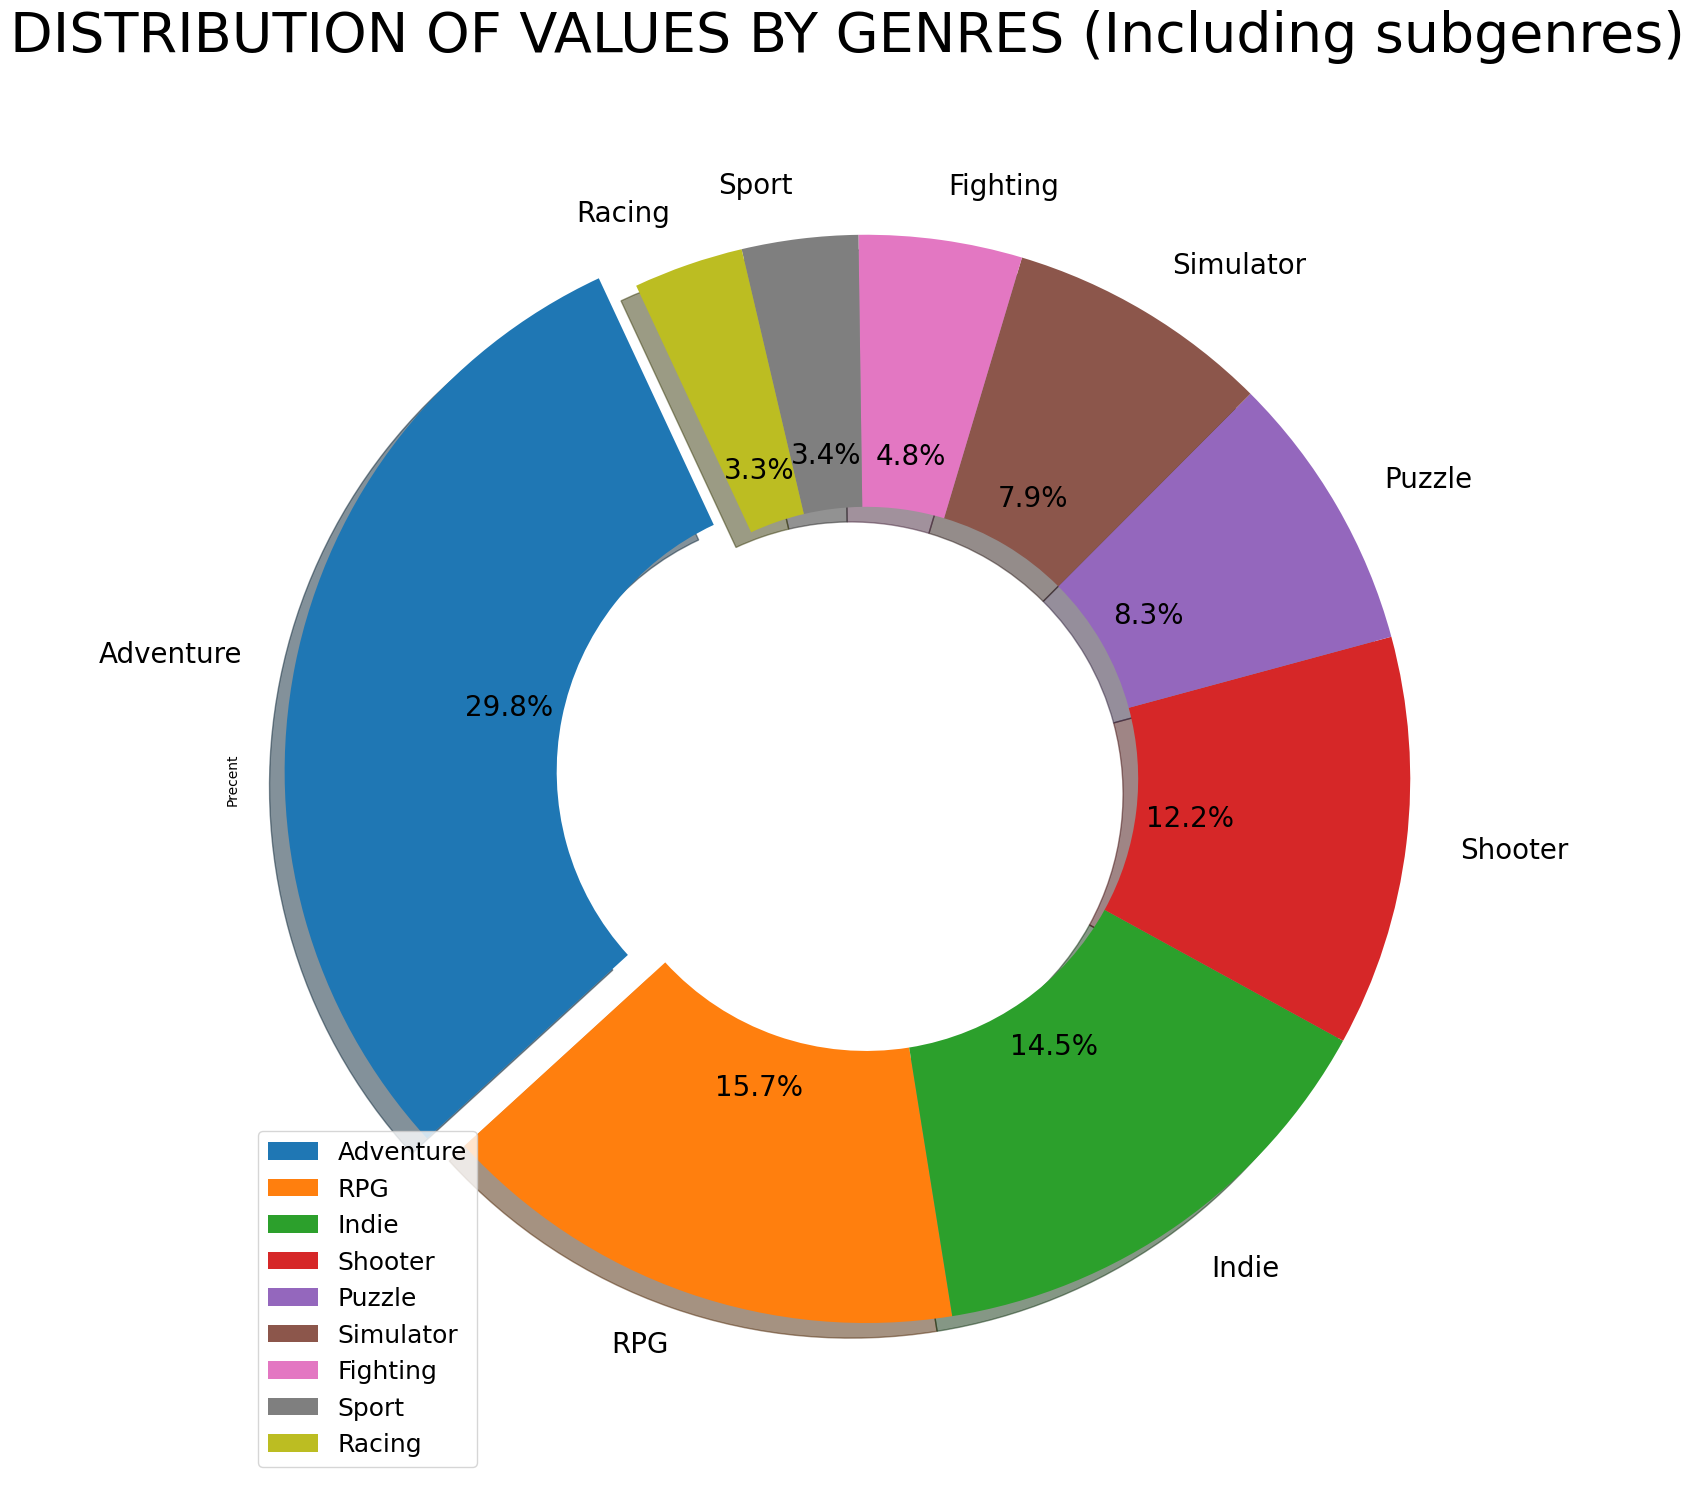

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
explode = [0.07,0,0,0,0,0,0,0,0]
ax = df_genres['Precent'].plot.pie(labels=df_genres['Genres'], ax=ax,\
                                  autopct='%1.1f%%',startangle=115,shadow=True,\
                                   wedgeprops=dict(width=0.5),explode=explode,fontsize=20)
ax.set_title('DISTRIBUTION OF VALUES BY GENRES (Including subgenres)',pad=20,fontsize=40)
mpl.rcParams['font.family'] = 'sans-serif'
ax.axis('equal')
ax.legend(loc='lower left',labels=df_genres['Genres'],fontsize=18)
plt.tight_layout()
plt.show()


<a id='sub_section_4_6'></a>

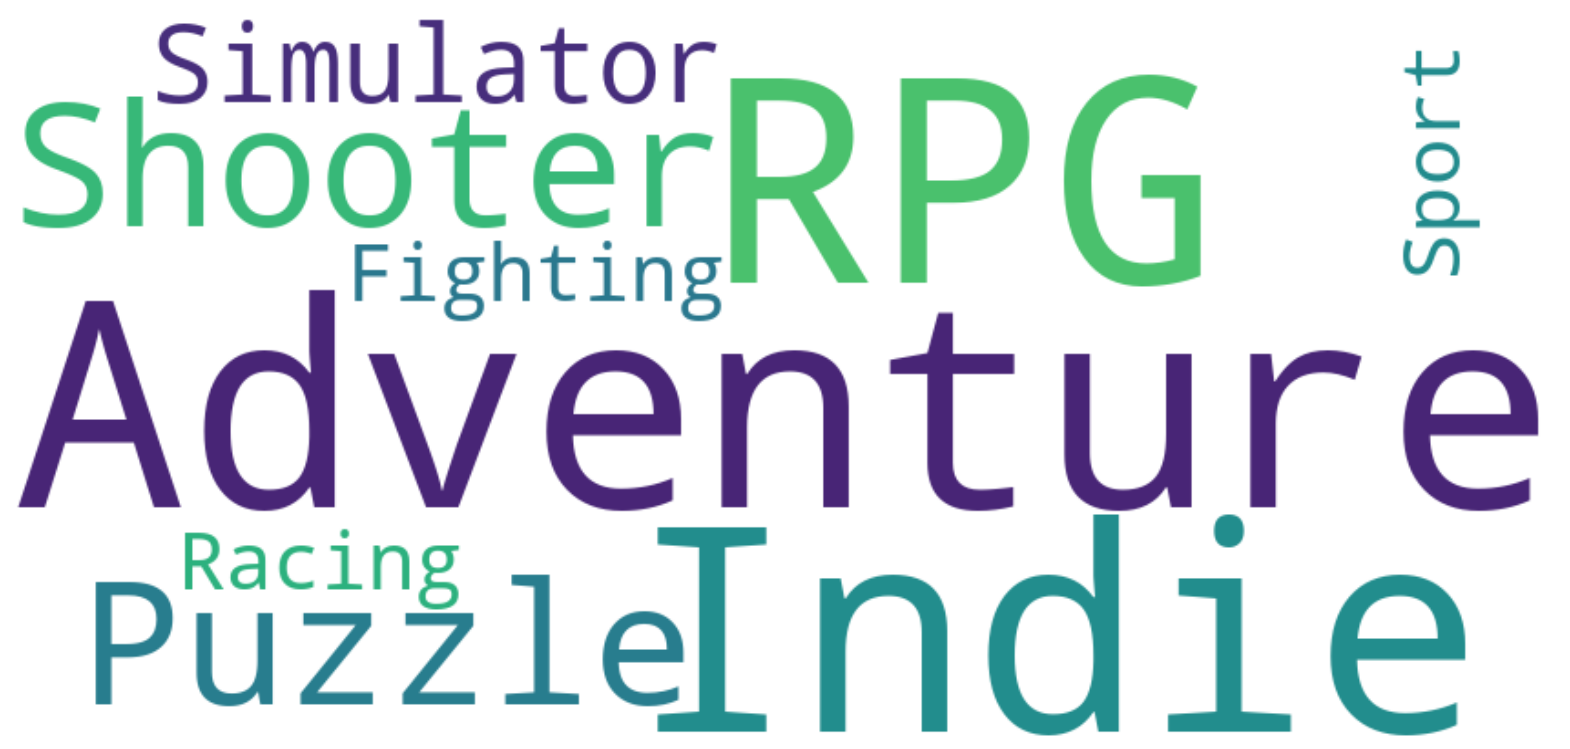

In [84]:
text_to_cloud = str(list(df_genres['Genres'])).replace(',','').replace('[','').replace(']','').replace("'",'')
plt.rcParams['figure.figsize'] = (20,20)
wordcloud = WordCloud(background_color = 'white', mode="RGB", width = 850, height = 400).generate(text_to_cloud)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
df_players_genre = pd.DataFrame({
    'Title' : games_df['Title'].tolist(),
    'Genres' : games_df['Genres'].tolist(),
    'Plays' : games_df['Plays'].tolist(),
    'Playing' : games_df['Playing'].tolist()})

df_players_genre = df_players_genre.explode('Genres')
df_players_genre = df_players_genre.groupby('Genres')[['Plays','Playing']].sum().reset_index()
df_players_genre = df_players_genre.loc[df_players_genre['Genres'].isin(top_10_main_genres)]
df_players_genre

Genres        Plays      Playing
0   Adventure  647202500.0  168688400.0
4    Fighting  134334600.0    8324200.0
5       Indie  297512800.0   50315700.0
11     Puzzle  185131600.0   25571000.0
13        RPG  352365900.0  107536200.0
14     Racing   82543800.0    6937000.0
16    Shooter  281775800.0   55746800.0
17  Simulator  185789600.0   24782600.0
18      Sport   92293000.0    5116000.0

<a id='sub_section_4_7'></a>

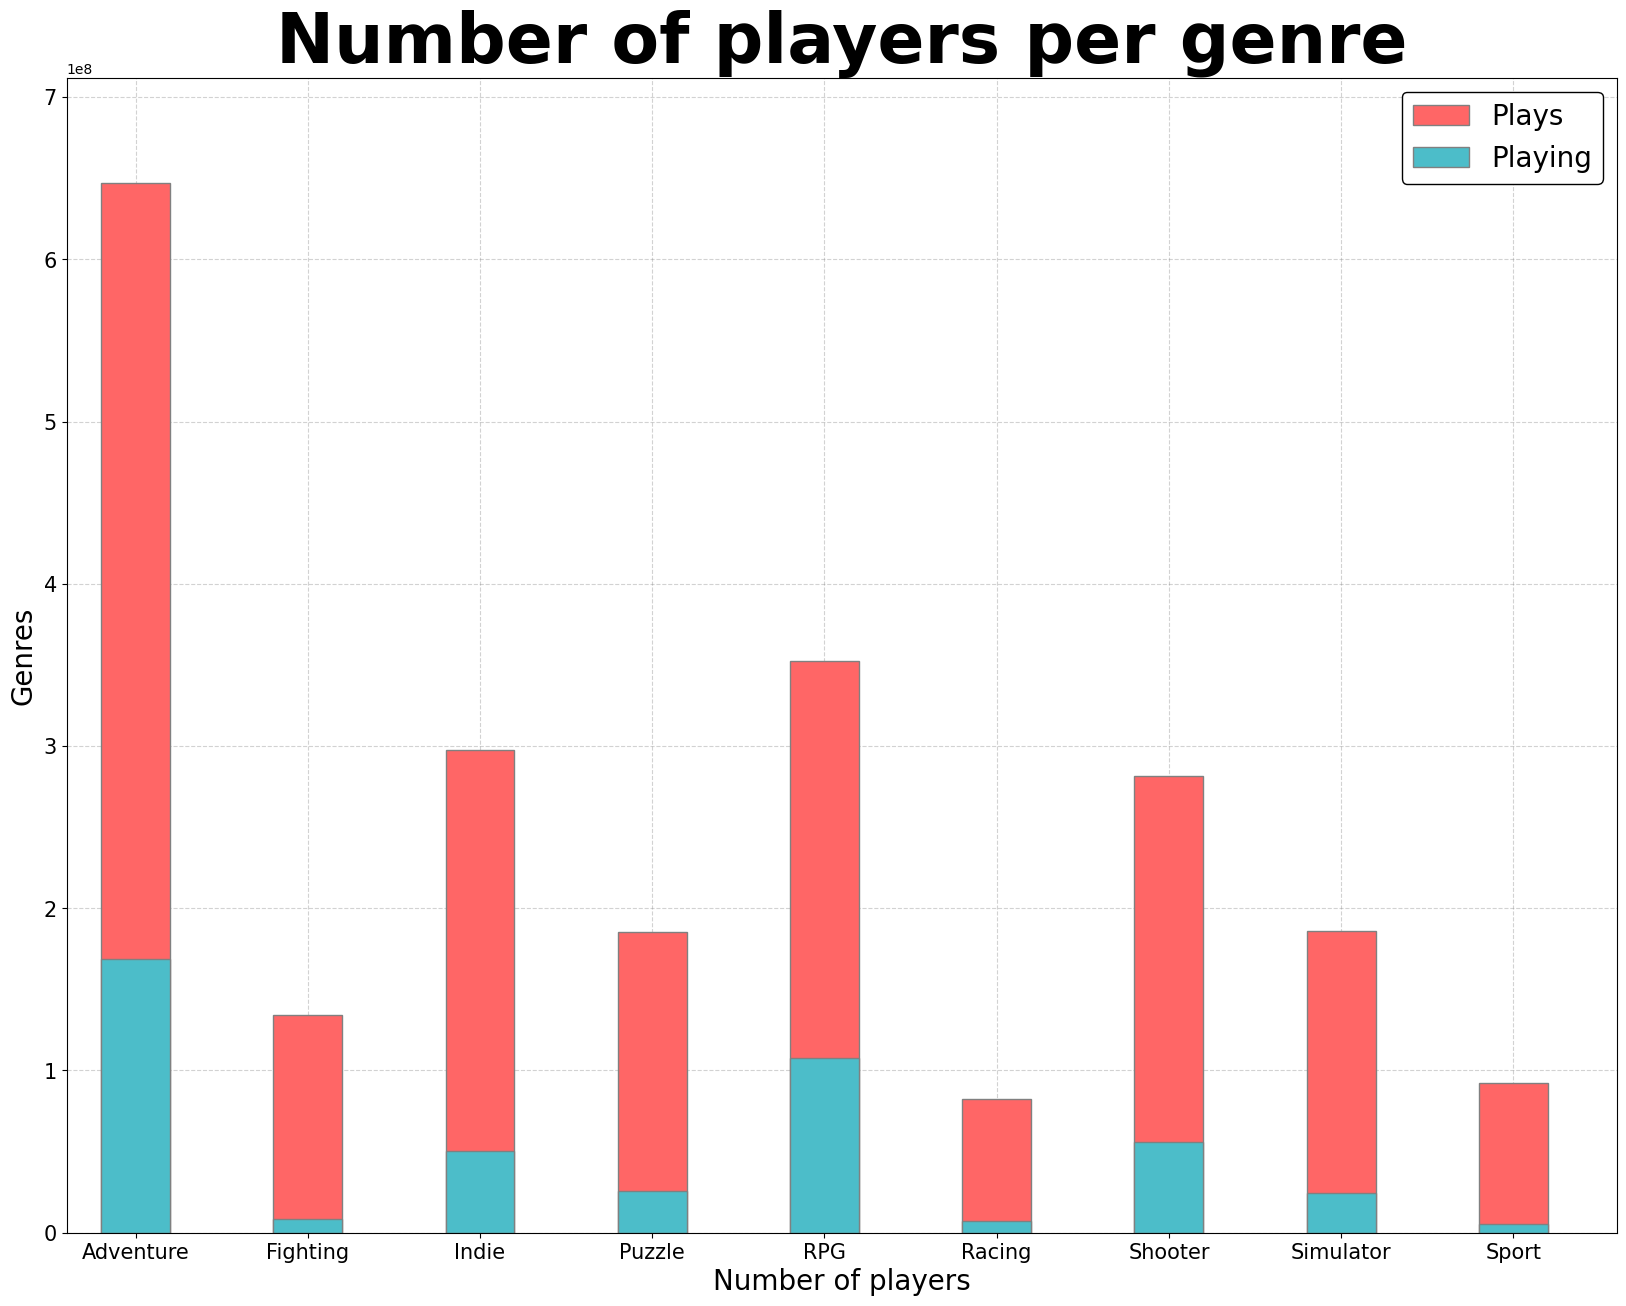

In [86]:
index = df_players_genre['Genres'].tolist()
val1 = df_players_genre['Plays'].tolist()
val2 = df_players_genre['Playing'].tolist()

fig, ax = plt.subplots(figsize=(20, 15))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
width = 0.4
bar1 = ax.bar(index, val1, width, label='Plays', edgecolor='gray',facecolor='#ff6666')
ax.bar(index, val2, width, label='Playing', edgecolor='gray',facecolor='#4cbdc9')
ax.set_xlim([-width, len(index)-width])
ax.set_ylim([0, max(max(val1),max(val2))*1.1])
ax.set_axisbelow(True)
ax.grid(True, color='gray',which='major',linestyle='--',alpha=0.35,zorder=-1)
ax.set_xlabel('Number of players', fontsize=20)
ax.set_ylabel('Genres', fontsize=20)
ax.set_title('Number of players per genre', fontweight='bold',fontsize = 50)
ax.legend(loc='upper right', facecolor='white', edgecolor='black', framealpha=1,fontsize=20)
plt.show()

<a id='chapter5'></a>
## Machine learning preperation

<a id='sub_section_5_1'></a>
### Text Analysis

In [327]:
df = pd.DataFrame({'Title': games_df['Title'].tolist(),\
                   'Description': games_df['Description'].tolist(),'Genres': games_df['Genres'].tolist()})
df = df.explode('Genres')
df = df[df['Genres'].isin(['Sport','Simulator','Shooter','RPG','Racing','Fighting'])]
df = df.sort_values(by='Genres', ascending=False)
df = df.drop_duplicates(subset='Title', keep='first')
df



Title   
2959                                 Motorsport Manager  \
4274                                          FIFA 2000   
6422                                          Surf's Up   
6421        Mario & Sonic at the Rio 2016 Olympic Games   
741                          Inazuma Eleven 2: Blizzard   
...                                                 ...   
6825                                    Art of Fighting   
4721               Dragon Ball Z: Supersonic Warriors 2   
3959                                     Kang Fu (1996)   
989                                 Akatsuki Blitzkampf   
1235  JoJo's Bizarre Adventure: Heritage for the Future   

                                            Description    Genres  
2959  Have you got what it takes to become the manag...     Sport  
4274                  Game Boy Color port of FIFA 2000.     Sport  
6422  When the Surf's Up, Cody Maverick comes runnin...     Sport  
6421  Mario & Sonic at the Rio 2016 Olympic Games is...     Sport  
741   Endou Mamoru (Mark Evans in the European versi...     Sport  
...                                                 ...       ...  
6825  This fighting game began the story of the Saka...  Fighting  
4721  Supersonic Warriors 2 is the DS sequel to the ...  Fighting  
3959               A side-scrolling game for Amiga CD32  Fighting  
989   Akatsuki Blitzkampf is a Japanese dōjin 2D fig...  Fighting  
1235  JoJo's Bizarre Adventure: Heritage for the Fut...  Fighting  

[4677 rows x 3 columns]

In [328]:
tokens = nltk.word_tokenize(' '.join(df.Description.values))
text = nltk.Text(tokens)
fdist = FreqDist(text)
print(fdist)
fdist.most_common(40)

<FreqDist with 26108 samples and 335873 outcomes>


[('the', 17472),
 (',', 16027),
 ('.', 13248),
 ('and', 10698),
 ('of', 9102),
 ('a', 7854),
 ('to', 7174),
 ('in', 5498),
 ('is', 4212),
 ('game', 3490),
 ('with', 2776),
 ('The', 2658),
 ('as', 2351),
 ('on', 2157),
 ('you', 2146),
 ('for', 2121),
 ('your', 1950),
 ('by', 1888),
 ('an', 1684),
 ("'s", 1546),
 ('from', 1523),
 (':', 1501),
 ('new', 1500),
 ('that', 1483),
 ('!', 1414),
 ('are', 1079),
 ('world', 1058),
 ('can', 982),
 ('or', 971),
 ('series', 969),
 ('will', 957),
 ('their', 897),
 ('players', 828),
 ('player', 819),
 ('it', 809),
 ('be', 798),
 ('up', 782),
 ('was', 777),
 ('It', 715),
 ('has', 704)]

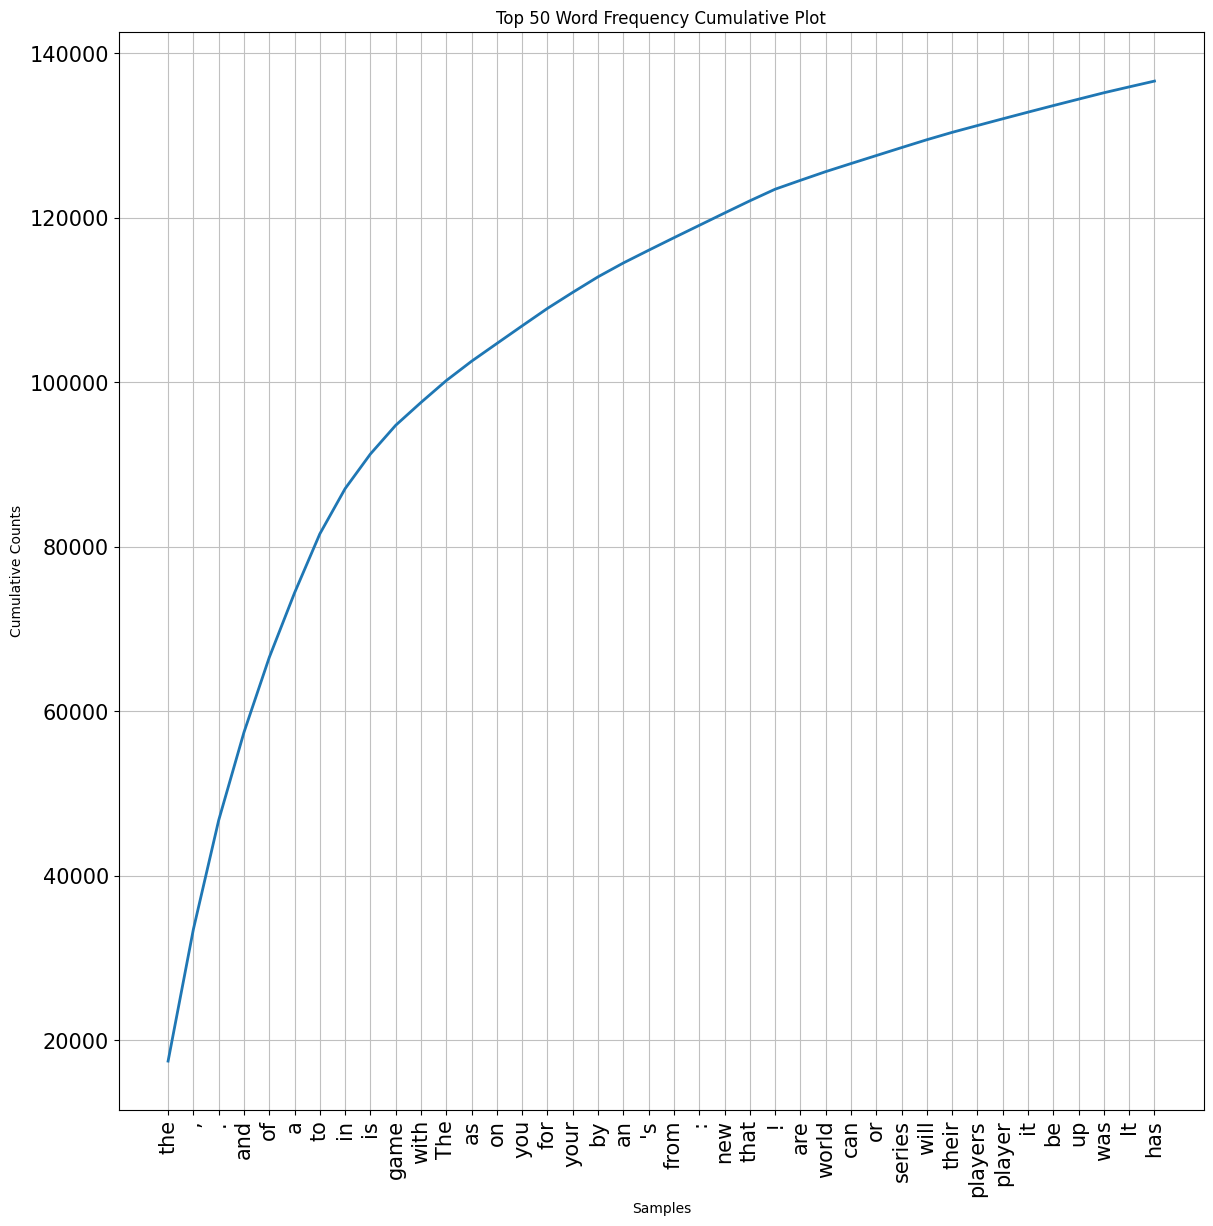

In [329]:
fig, ax = plt.subplots(figsize=(14,14))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fdist.plot(40, cumulative=True, title='Top 50 Word Frequency Cumulative Plot')
ax.set_title('Top 50 Word Frequency Cumulative Plot', fontsize=30)
plt.show()

<a id='sub_section_5_2'></a>
### Collocations
*Collocations present the commonly occuring biagrams or words that tend to follow one*another.

In [330]:
text.collocations()

video game; Mega Man; Final Fantasy; Resident Evil; North America;
Street Fighter; Kingdom Hearts; takes place; Dragon Ball; Star Wars;
Xbox 360; Fire Emblem; game developed; Game Boy; fighting game; FINAL
FANTASY; Mortal Kombat; first-person shooter; open world; Theft Auto


<a id='sub_section_5_3'></a>
### Lexical Diversity

In [331]:
genres = list(df['Genres'].unique())
dictionary = {}
for genre in genres:
    descs = list(df[df['Genres'] == genre].Description.values)
    tokens = nltk.word_tokenize(' '.join(descs))
    types = set(tokens)
    lexical_diversity = round(len(types) / len(tokens),3)
    dictionary[genre] = (len(tokens), len(types), lexical_diversity)

table = pd.DataFrame.from_dict(dictionary, orient='index', columns=['Tokens','Type','Lexical Diversity'])
display(table.sort_values('Lexical Diversity'))

Tokens   Type  Lexical Diversity
RPG        106322  12425              0.117
Shooter     96969  12321              0.127
Simulator   54247   9349              0.172
Fighting    30820   5368              0.174
Sport       31074   5745              0.185
Racing      16441   3733              0.227

<a id='sub_section_5_4'></a>
### Data Cleaning and Auditing

In [332]:
def text_cleaner(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    roman_re = r'\bM{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\b'
    tokens = [t for t in tokens if not re.match (roman_re, t, flags=re.IGNORECASE).group()]
    text = ' '.join(tokens).strip()
    return text

In [333]:
df['Description'] = df['Description'].apply(lambda n: text_cleaner(n))
df.sample(20)

Title   
6386                                          The Club  \
7236                                Murderous Pursuits   
1277           Wing Commander IV: The Price of Freedom   
6094                         Pokémon Battle Revolution   
4320                                       Luftrausers   
2136  Atelier Ryza: Ever Darkness & the Secret Hideout   
1168                                    Pokémon Silver   
6434                                     AFL Evolution   
4021                                   Earthworm Jim 2   
5658                                      I Am Setsuna   
3709                       Instant Sports Winter Games   
112            The Legend of Zelda: Breath of the Wild   
2623                          Crypt of the NecroDancer   
4126                                    Secret of Mana   
1677                               Oxygen Not Included   
5171                                      Tokyo Xanadu   
149               Resident Evil 4: Ultimate HD Edition   
6666                                Double Kick Heroes   
2221                                Final Fantasy VIII   
687                                                 Ib   

                                            Description     Genres  
6386  club new breed shooter combining run gun gamep...    Shooter  
7236  welcome murderous pursuits multiplayer aristoc...  Simulator  
1277  year four years treaty torgo end kilrathi war ...  Simulator  
6094  pokémon battle revolution features three main ...        RPG  
4320  skies set aflame seas overflow wreckage vlambe...  Simulator  
2136  next game atelier franchise start new series g...        RPG  
1168  pokémon silver along pokémon gold sequels poké...        RPG  
6434  experience evolution afl evolution brings inte...      Sport  
4021  evil cat circus scars planet meat join jim mad...    Shooter  
5658  setsuna introduces authentic jrpg style yester...        RPG  
3709  breakfirst games games pid games pleased unvei...      Sport  
112   legend zelda breath wild first game zelda seri...        RPG  
2623  crypt necrodancer hardcore roguelike rhythm ga...        RPG  
4126  initially released japan secret mana took worl...        RPG  
1677  oxygen included simulation game deep inside al...  Simulator  
5171  tokyo xanadu upcoming japanese video game play...        RPG  
149   resident evil ultimate hd edition second port ...    Shooter  
6666  double kick heroes mixes rhythm game must surv...    Shooter  
2221  final fantasy eighth main installment final fa...        RPG  
687   ib remake original exploration adventure game ...        RPG

<a id='sub_section_5_5'></a>
### Genres balance analyze

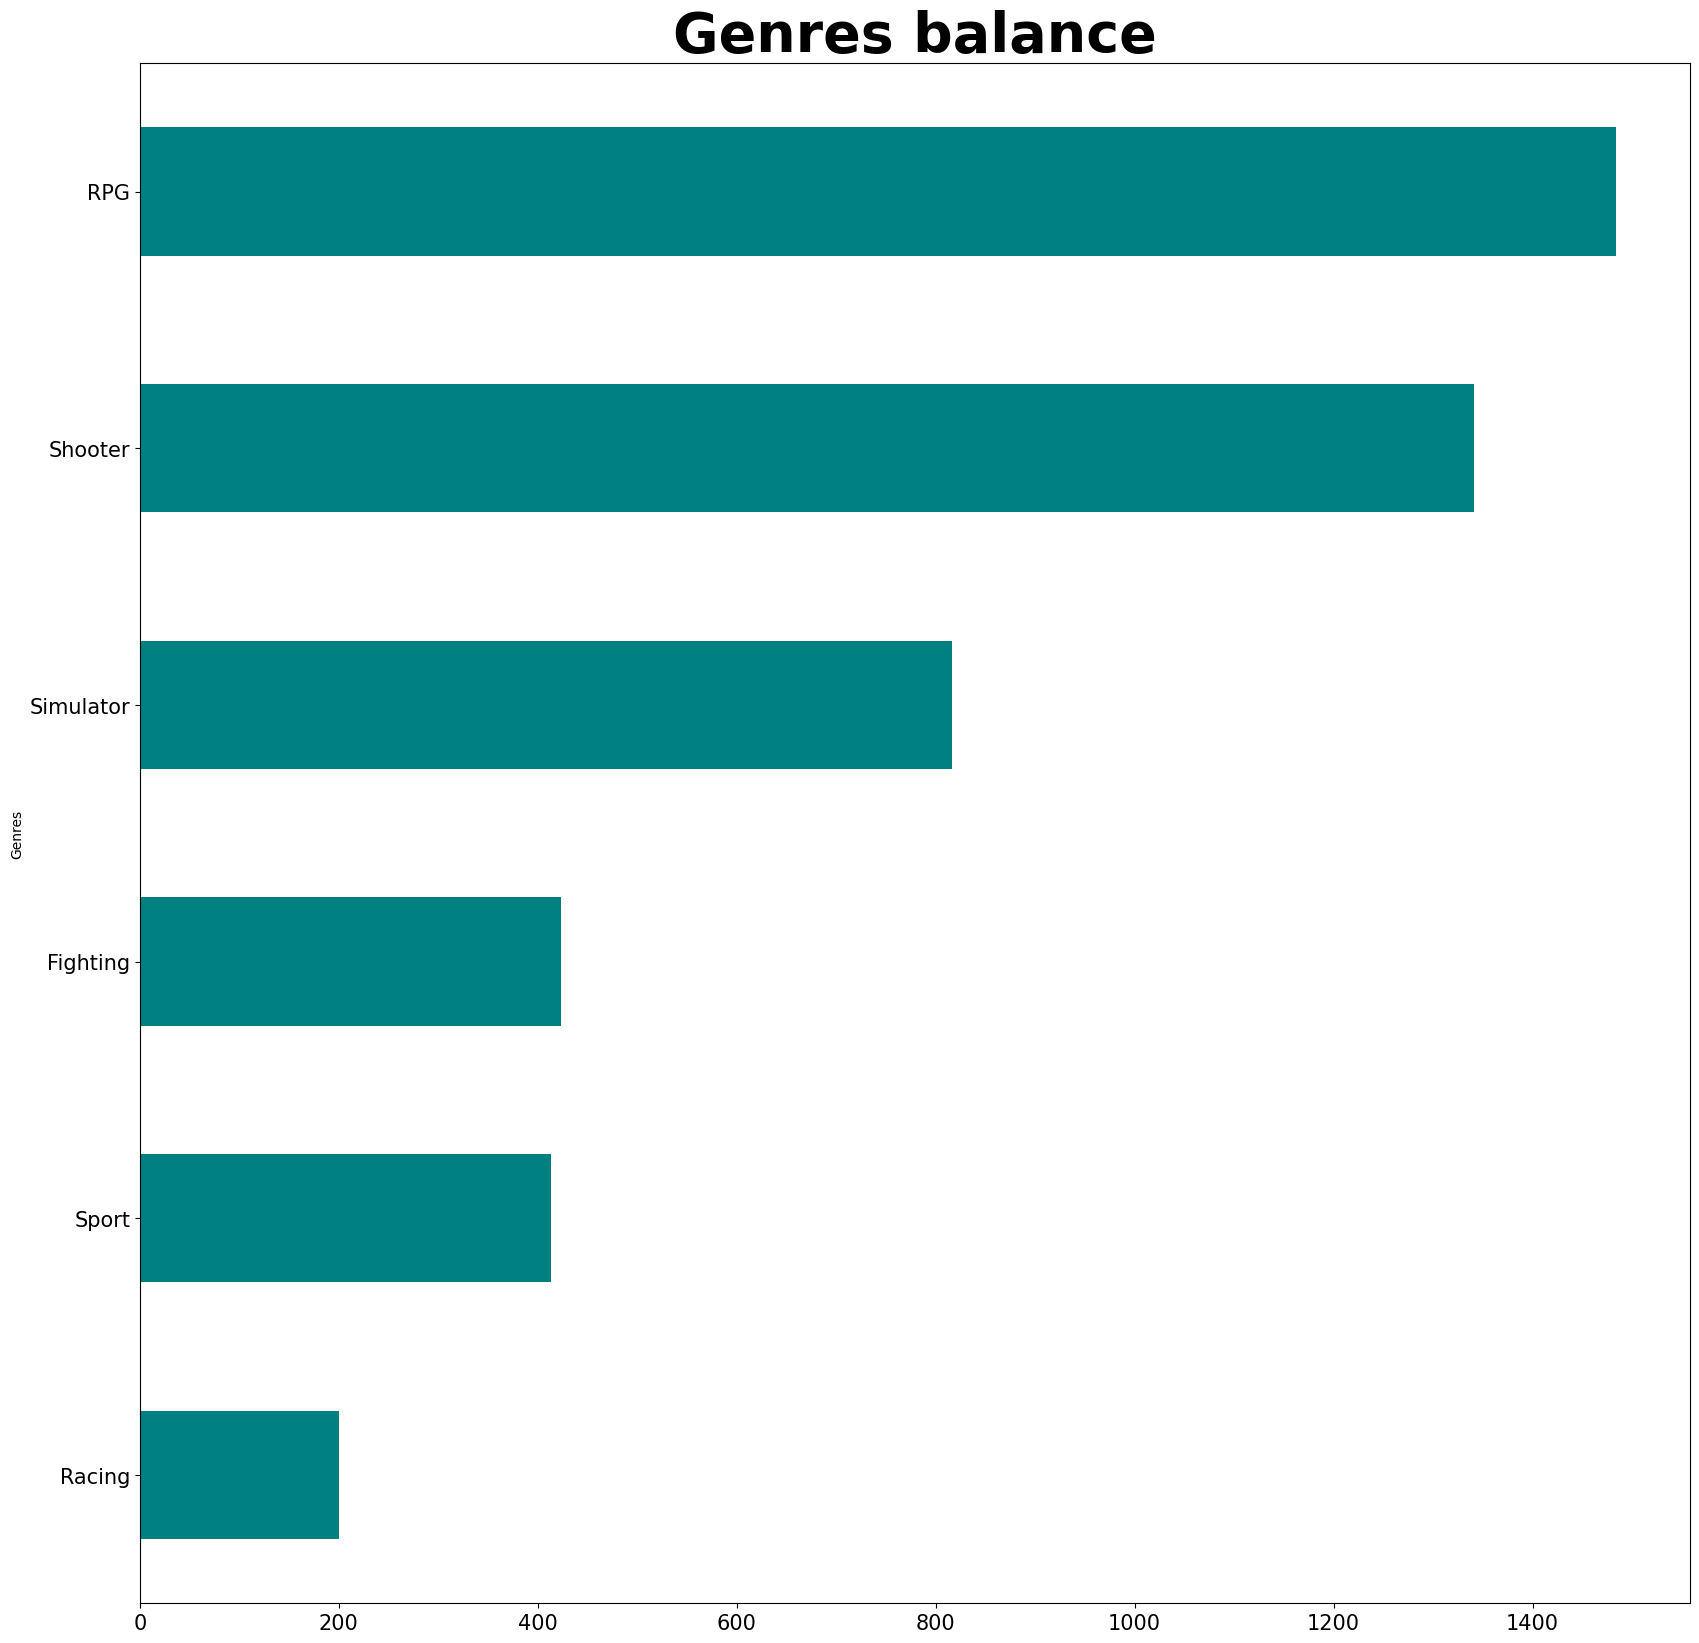

In [334]:
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.set_size_inches(6,6)
plt.title('Genres balance', fontsize = 40, fontweight='bold')
df['Genres'].value_counts(ascending=True).plot(kind='barh', color='#008080')
plt.show()

<a id='sub_section_5_6'></a>
### Post-cleaning analysis

In [335]:
def stemm_cleaner(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [336]:
genres = list(df['Genres'].unique())
stemmer = nltk.SnowballStemmer("english")
df['Description'] = df['Description'].apply(stemm_cleaner)
dictionary = {}
for genre in genres:
    descs = list(df[df['Genres'] == genre].Description.values)
    tokens = nltk.word_tokenize(' '.join(descs))
    types = set(tokens)
    lexical_diversity = round(len(types) / len(tokens),3)
    dictionary[genre] = (len(tokens), len(types), lexical_diversity)

table = pd.DataFrame.from_dict(dictionary, orient='index', columns=['Tokens','Type','Lexical Diversity'])
display(table.sort_values('Lexical Diversity'))

Tokens  Type  Lexical Diversity
RPG         52757  6821              0.129
Shooter     48074  6624              0.138
Simulator   26740  5259              0.197
Fighting    15661  3151              0.201
Sport       15640  3275              0.209
Racing       8166  2281              0.279

In [337]:
tokens = nltk.word_tokenize(' '.join(df['Description'].values))
text = nltk.Text(tokens)
fdist = FreqDist(text)
print(fdist)
fdist.most_common(40)

<FreqDist with 12974 samples and 167038 outcomes>


[('game', 4365),
 ('player', 1859),
 ('new', 1629),
 ('world', 1366),
 ('charact', 1067),
 ('seri', 985),
 ('take', 852),
 ('featur', 831),
 ('fight', 801),
 ('battl', 800),
 ('play', 714),
 ('releas', 700),
 ('use', 697),
 ('one', 681),
 ('first', 639),
 ('time', 626),
 ('action', 615),
 ('stori', 603),
 ('set', 588),
 ('mode', 573),
 ('adventur', 557),
 ('includ', 554),
 ('power', 544),
 ('enemi', 530),
 ('race', 529),
 ('develop', 527),
 ('experi', 523),
 ('also', 514),
 ('control', 512),
 ('origin', 487),
 ('weapon', 479),
 ('gameplay', 477),
 ('explor', 438),
 ('version', 432),
 ('two', 419),
 ('video', 412),
 ('system', 410),
 ('combat', 404),
 ('way', 396),
 ('level', 378)]

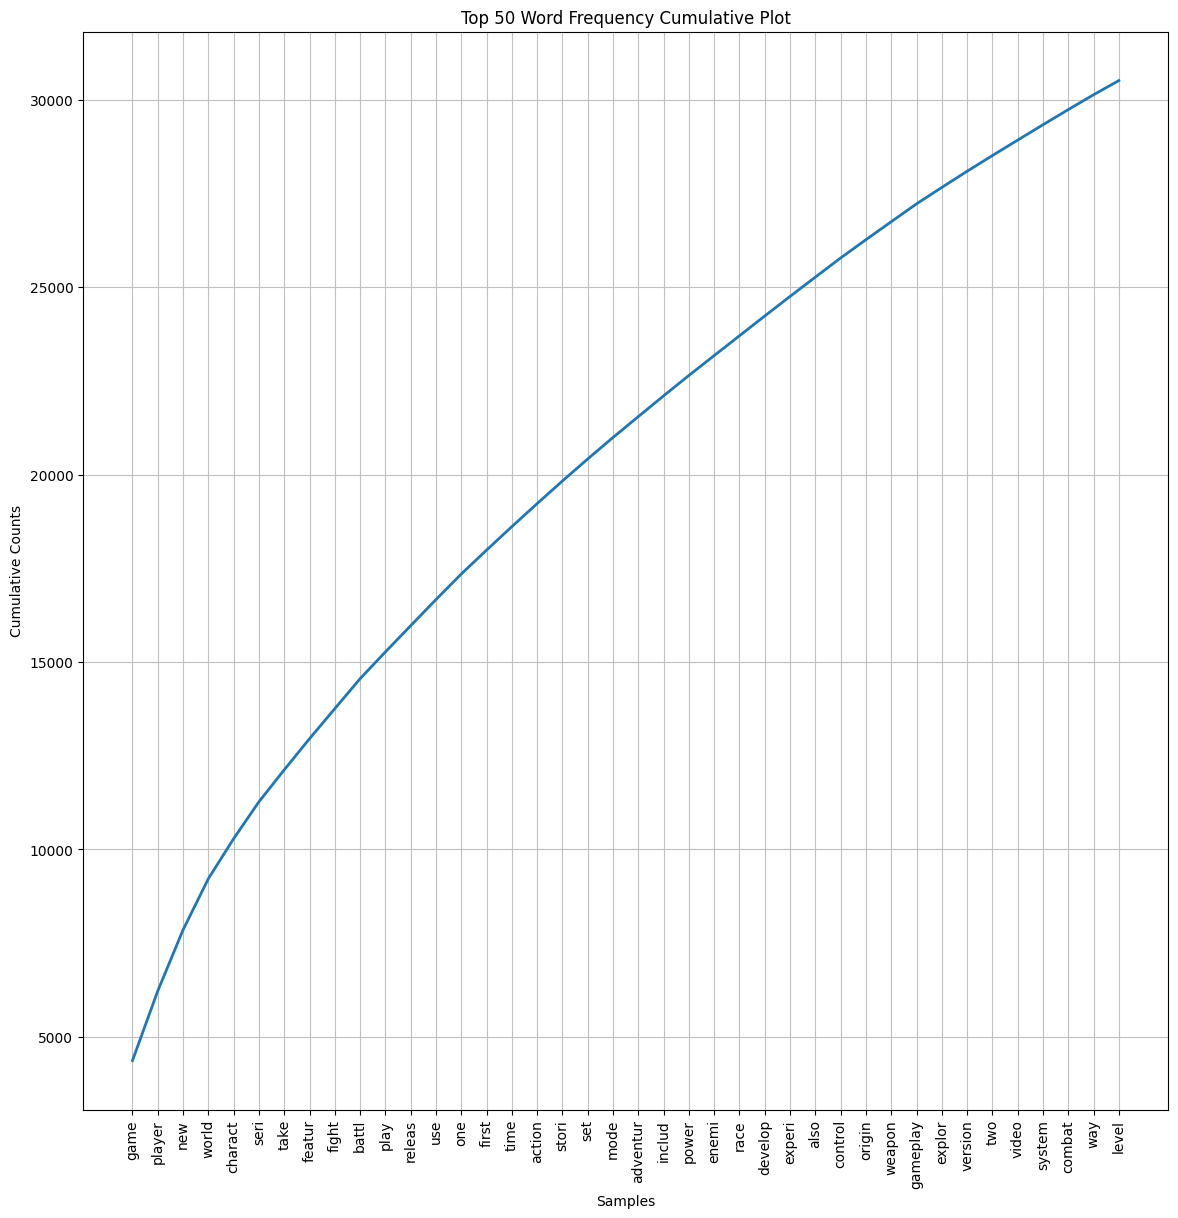

In [338]:
fig, ax = plt.subplots(figsize=(14,14))
fdist.plot(40, cumulative=True, title='Top 50 Word Frequency Cumulative Plot')
ax.set_title('Top 50 Word Frequency Cumulative Plot', fontsize=30)
plt.show()

<a id='sub_section_5_7'></a>
### Common words per genre

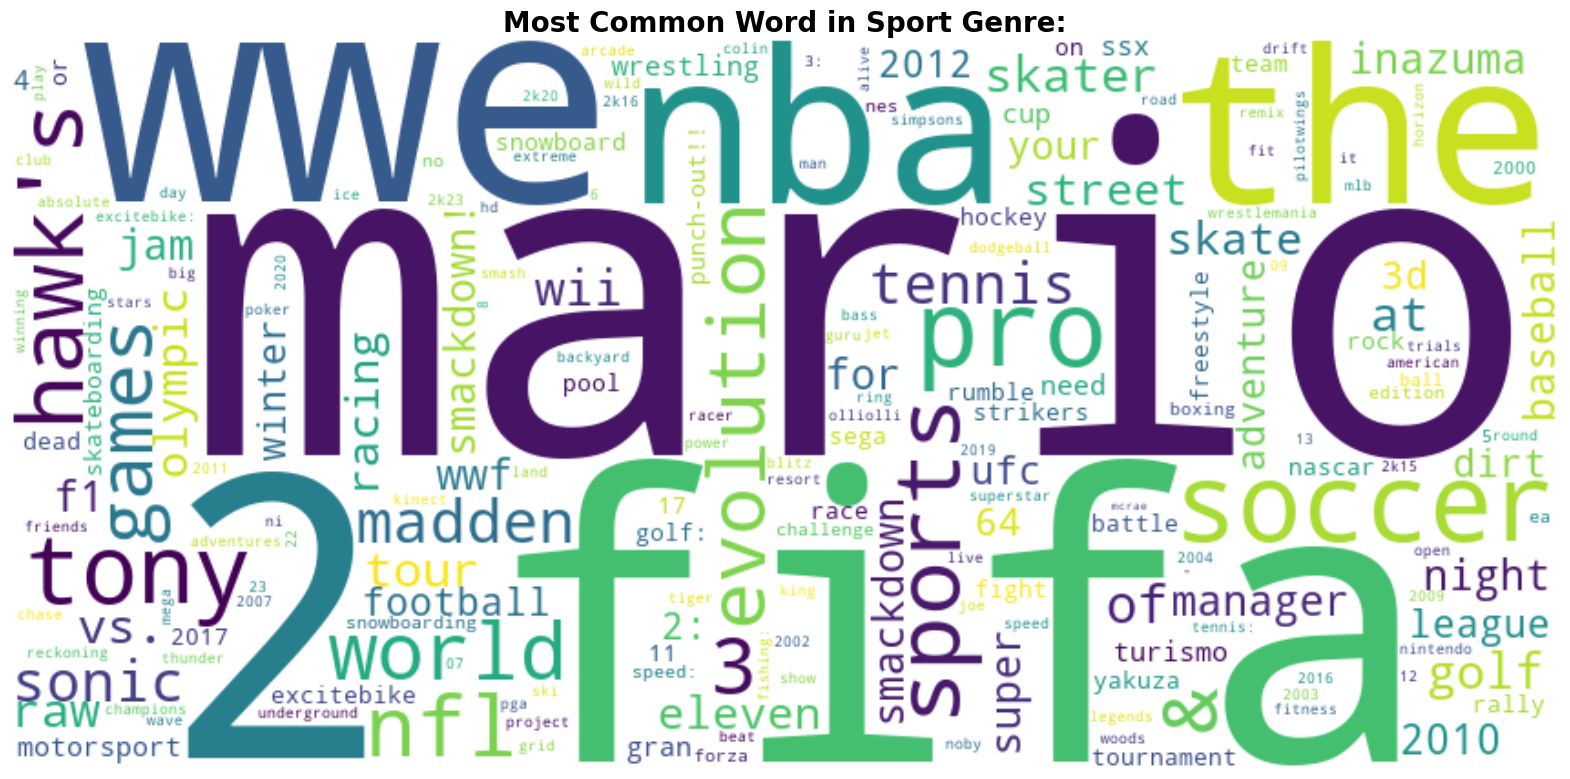

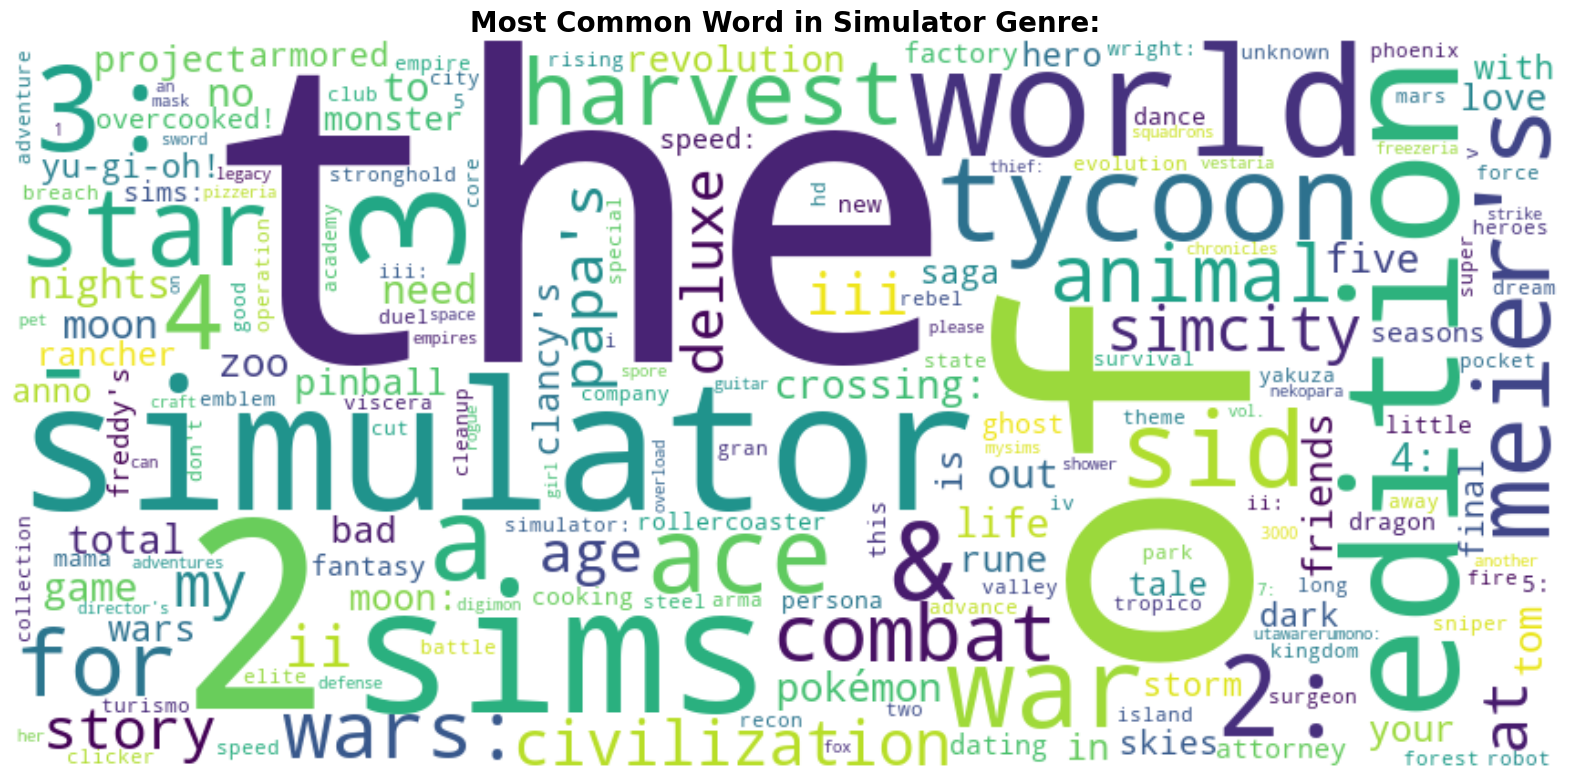

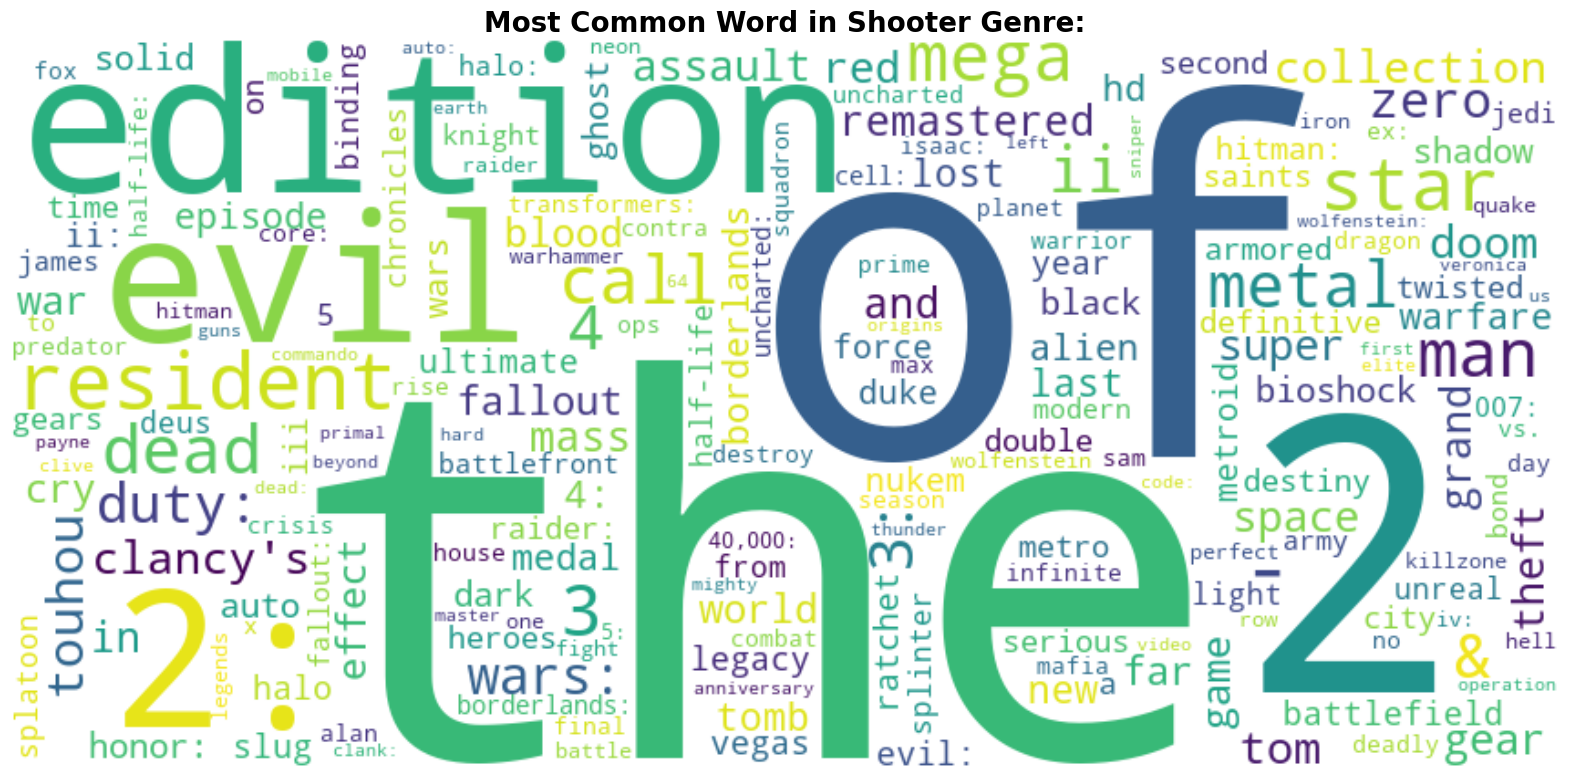

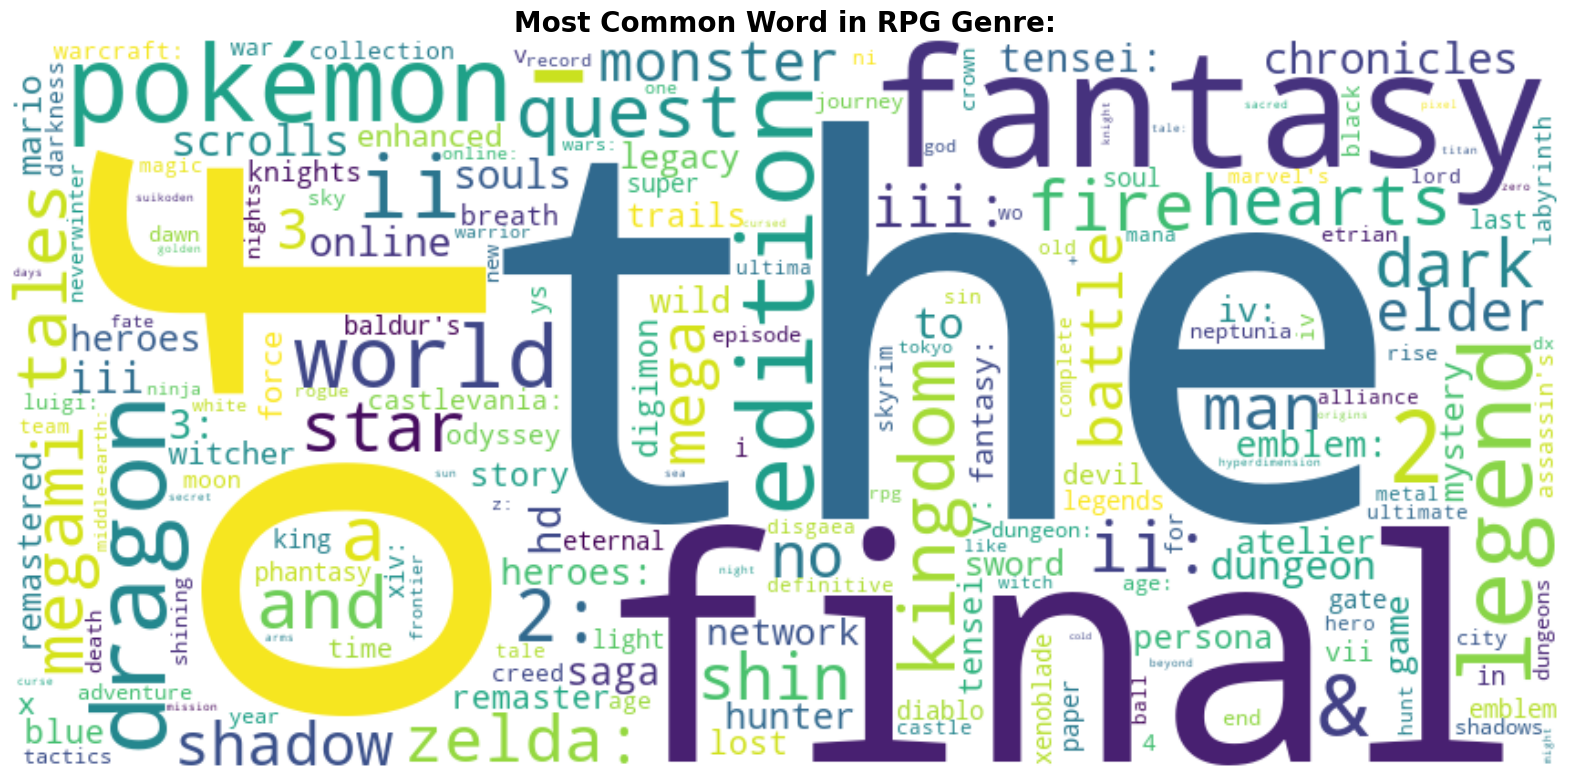

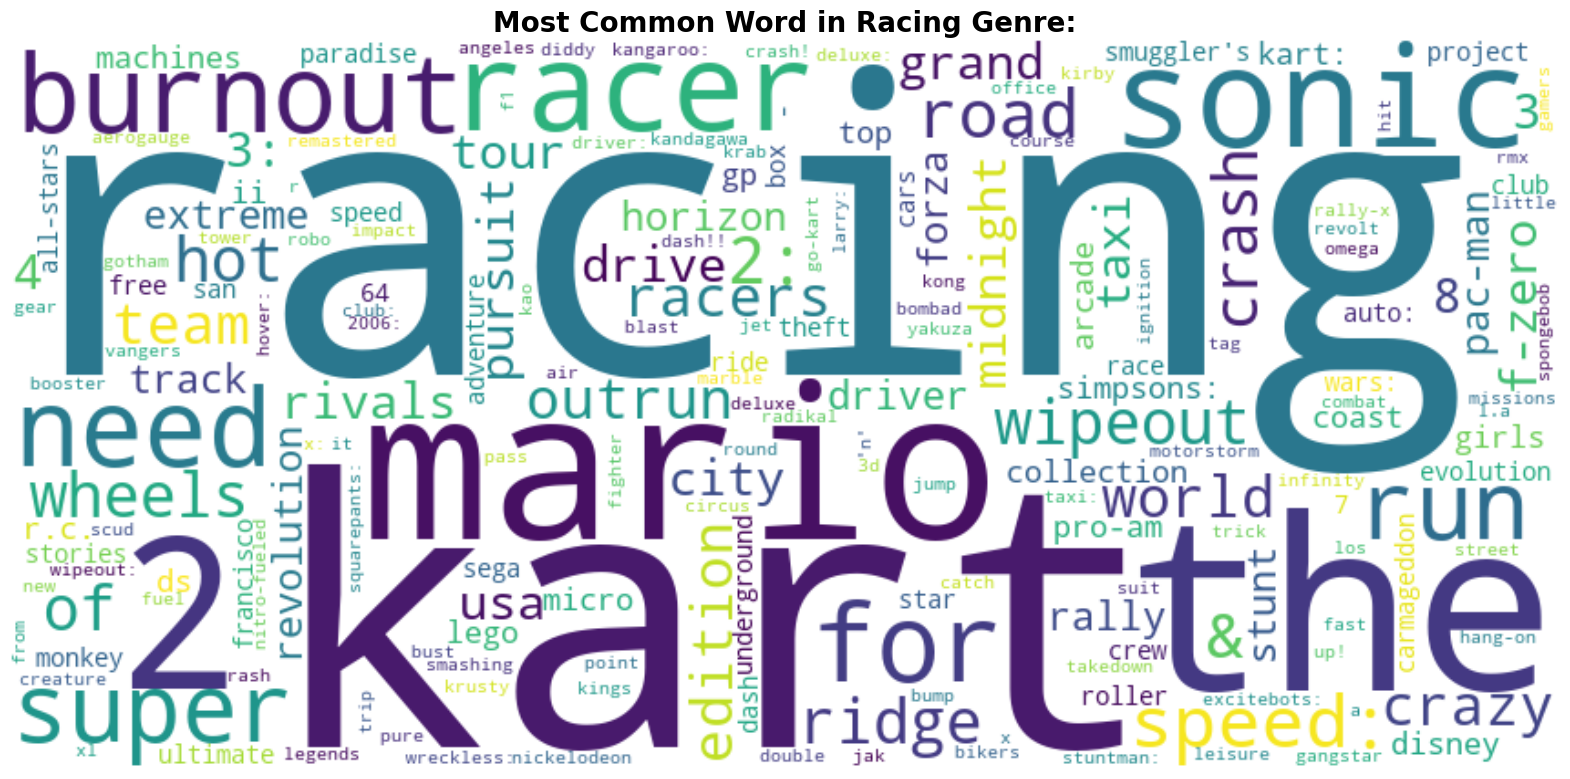

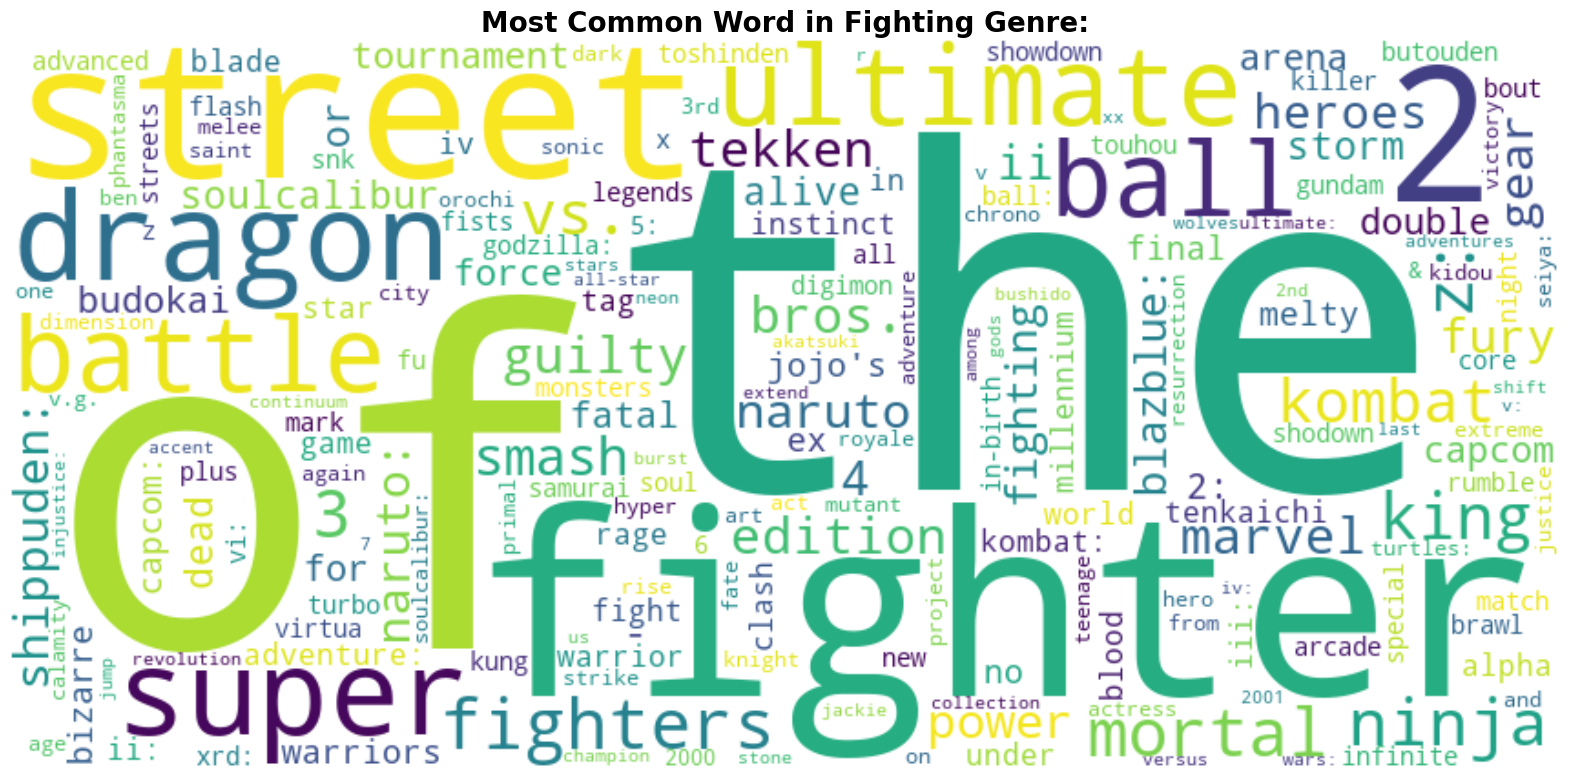

In [378]:
genres = ['Sport','Simulator','Shooter','RPG','Racing','Fighting']

game_titles = {genre: [] for genre in genres}

for index, row in df.iterrows():
    genre = row['Genres']
    title = row['Title']
    if genre in game_titles:
        game_titles[genre].append(title)

word_counts = {genre: collections.Counter(' '.join(game_titles[genre]).lower().split()) for genre in genres}

for genre in genres:
    counts = word_counts[genre]
    wordcloud = WordCloud(background_color='white', mode="RGB", width = 850, height = 400).generate_from_frequencies(counts)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Most Common Word in {genre} Genre:", fontsize=20, fontweight='bold')
    plt.axis('off')
    plt.show()
    print("\n\n\n")
    


<a id='chapter6'></a>
## Genre Classification Model :) 
<a id='sub_section_6_1'></a>
*In this section we will use the Pipeline with CountVectorizer, TFIDF, MultinomialNB algorithms (Based on internet explore for the project).*

In [347]:
TFIDF_vectorizer = TfidfVectorizer(analyzer='word')
df = df.sample(frac = 1)
X = df['Description']
y = df['Genres']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
xtrain_TFIDF = TFIDF_vectorizer.fit_transform(Xtrain)
xtest_TFIDF = TFIDF_vectorizer.transform(Xtest)
lr = LogisticRegression(max_iter=10000)
lr.fit(xtrain_TFIDF, ytrain)
lr_pred = lr.predict(xtest_TFIDF)
lr_acc = metrics.accuracy_score(ytest, lr_pred)
lr_acc = round(lr_acc, 2)

In [348]:
print(f'~~~Accuracy Scores~~~')
print(f'Logistic Regression: {lr_acc}')

~~~Accuracy Scores~~~
Logistic Regression: 0.71


In [349]:
pred_df = pd.DataFrame(Xtest)
pred_df['Actual'] = ytest
pred_df['Prediction'] = lr_pred
pred_df.sample(10)

Description     Actual Prediction
2150  alien land futurist los angel duke bring pain ...    Shooter    Shooter
6367  master time becom ultim weapon aiden krone mad...    Shooter    Shooter
7035  omega quintet hybrid idol simul game japanes g...        RPG  Simulator
1602  shadow heart first offici game shadow heart se...        RPG        RPG
6408         third game ar tonelico seri first playstat        RPG        RPG
4613  call duti modern warfar shooter video game dev...    Shooter    Shooter
148   come age stori set protagonist friend journey ...  Simulator        RPG
2964  raidou kuzunoha privat detect japan taishou pe...        RPG        RPG
3267  mario paint educ game allow anyon creat simpl ...  Simulator  Simulator
4619  inspir realiti counter terrorist oper across w...    Shooter    Shooter

In [350]:
print(metrics.classification_report(ytest, lr_pred))

              precision    recall  f1-score   support

    Fighting       0.84      0.51      0.64        84
         RPG       0.69      0.85      0.76       312
      Racing       0.78      0.38      0.51        37
     Shooter       0.67      0.87      0.75       252
   Simulator       0.71      0.42      0.53       173
       Sport       0.89      0.60      0.72        78

    accuracy                           0.71       936
   macro avg       0.76      0.61      0.65       936
weighted avg       0.72      0.71      0.69       936



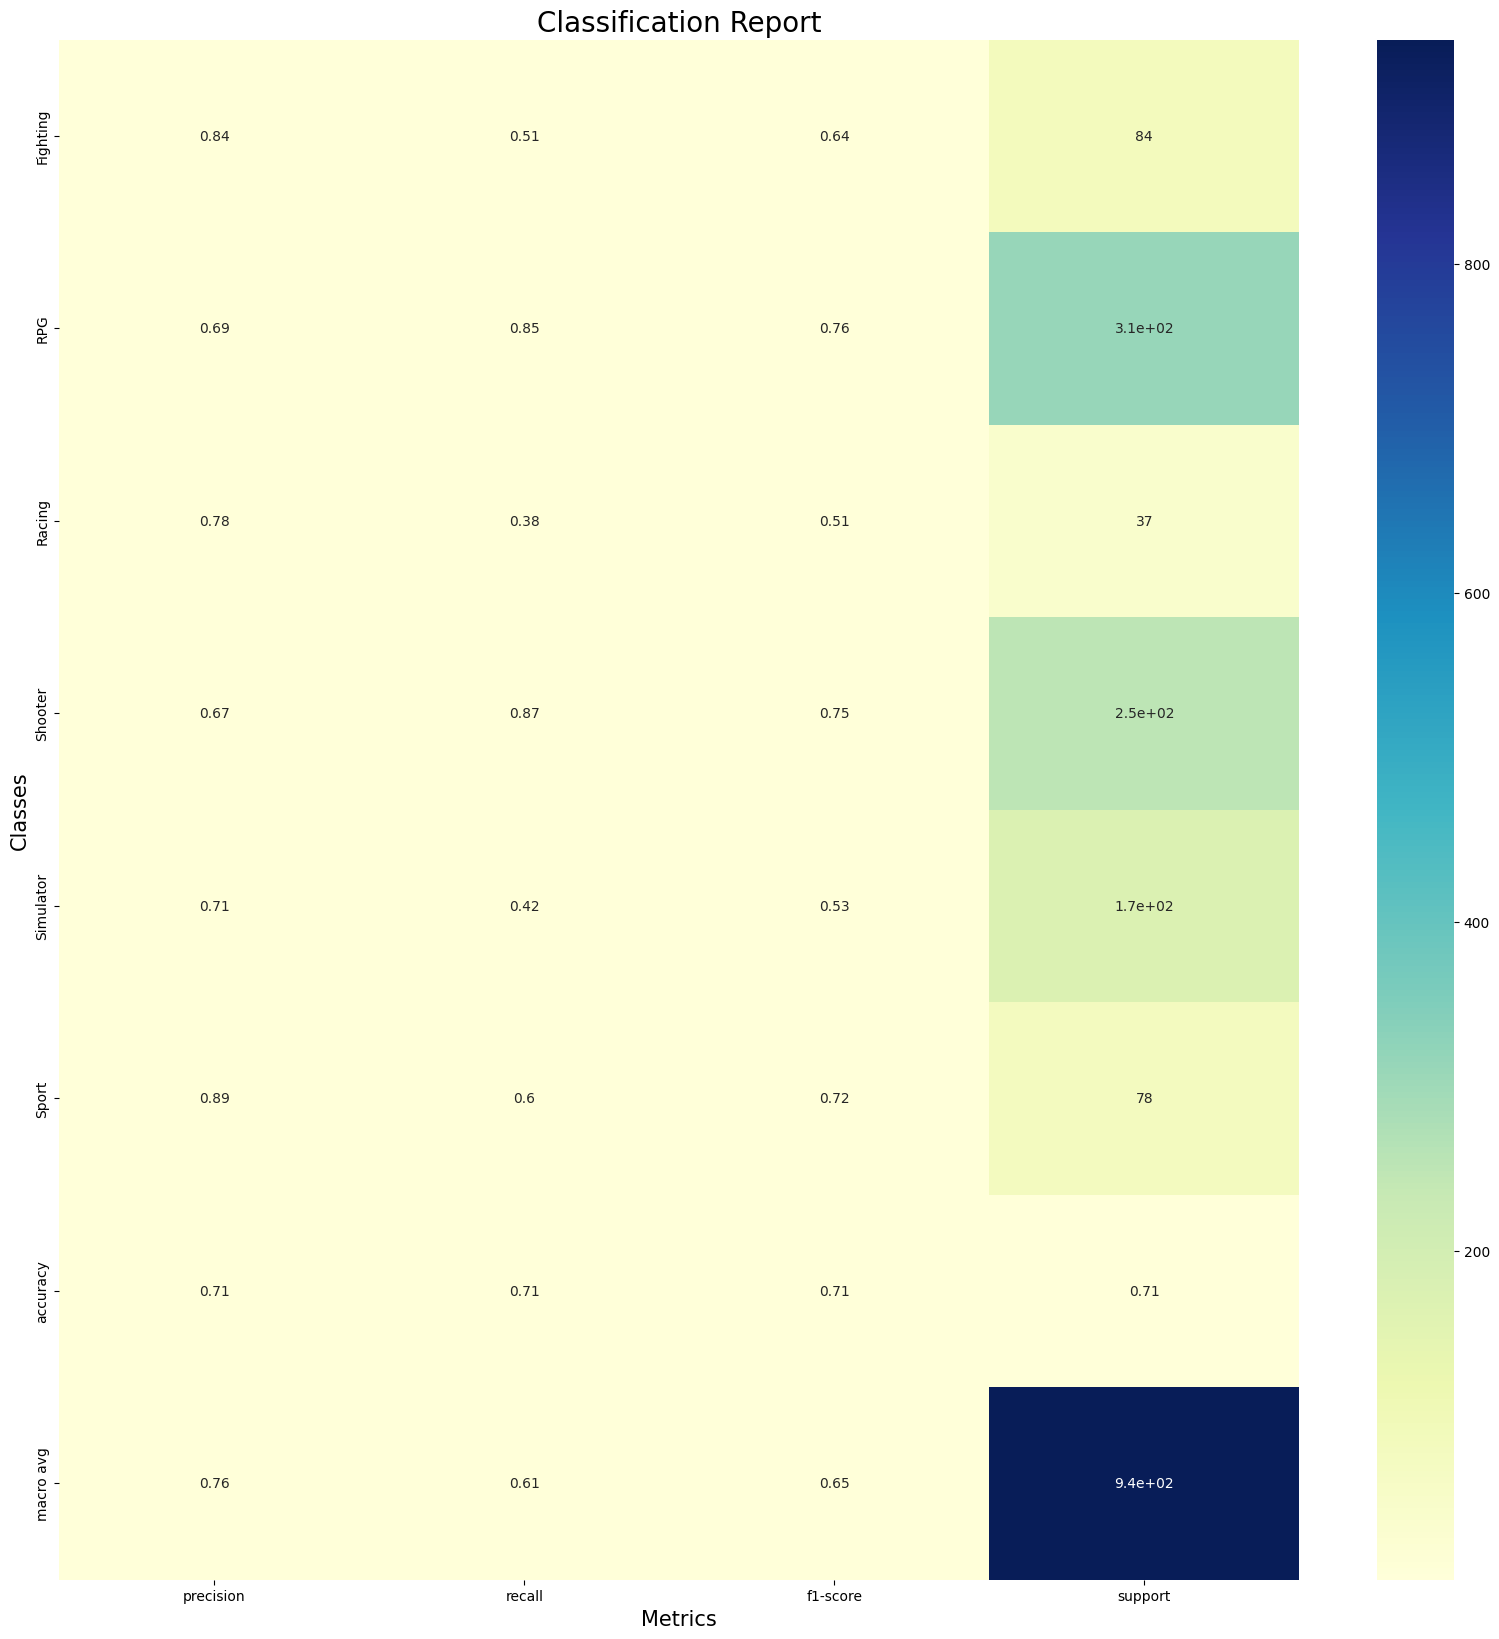

In [351]:
report = classification_report(ytest, lr_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu")
plt.title("Classification Report", fontsize=20)
plt.xlabel("Metrics", fontsize=15)
plt.ylabel("Classes", fontsize=15)
plt.show()

<a id='sub_section_6_2'></a>
### CountVectorizer & SGDClassifier - Pipeline

In [352]:
df = df.sample(frac = 1)
X = df['Description']
y = df['Genres']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

text_clf_svm = Pipeline([
    ('vect', CountVectorizer(stop_words="english",max_features=10000)),
    ('norm', preprocessing.Normalizer(norm='l1')),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])
text_clf_svm.fit(Xtrain, ytrain)
predicted = text_clf_svm.predict(Xtest)
print(f"Accuracy = {round(np.mean(predicted == ytest),2)}")

Accuracy = 0.67


In [353]:
df_model = pd.DataFrame({"Desc":Xtest, "ACTUAL":ytest, "Predicted":predicted})
df_model.sample(10)

Desc     ACTUAL  Predicted
2321  caesar part sierra citi build seri releas octo...  Simulator  Simulator
5758  elliot quest player explor mysteri urel island...        RPG        RPG
6244  one franchis time avail free jump one favorit ...  Simulator   Fighting
7022  final fantasi year direct sequel final fantasi...        RPG        RPG
4567  rpg dungeon crawler use team five charact five...        RPG        RPG
5991  adventur begin stage rpg revu starlight live d...        RPG        RPG
5726  huge air phat move sick trick race real bmx bi...      Sport      Sport
2282  mlb show deliv realist person basebal game exp...      Sport    Shooter
6870  chemic spill somewher rural england mutat armi...    Shooter    Shooter
2638  polish graphic enhanc gameplay updat featur wo...    Shooter        RPG

In [354]:
print(metrics.classification_report(ytest, predicted))

              precision    recall  f1-score   support

    Fighting       0.76      0.55      0.64        87
         RPG       0.59      0.88      0.70       275
      Racing       0.67      0.53      0.59        45
     Shooter       0.70      0.76      0.73       278
   Simulator       0.75      0.33      0.46       164
       Sport       0.89      0.55      0.68        87

    accuracy                           0.67       936
   macro avg       0.73      0.60      0.63       936
weighted avg       0.70      0.67      0.65       936



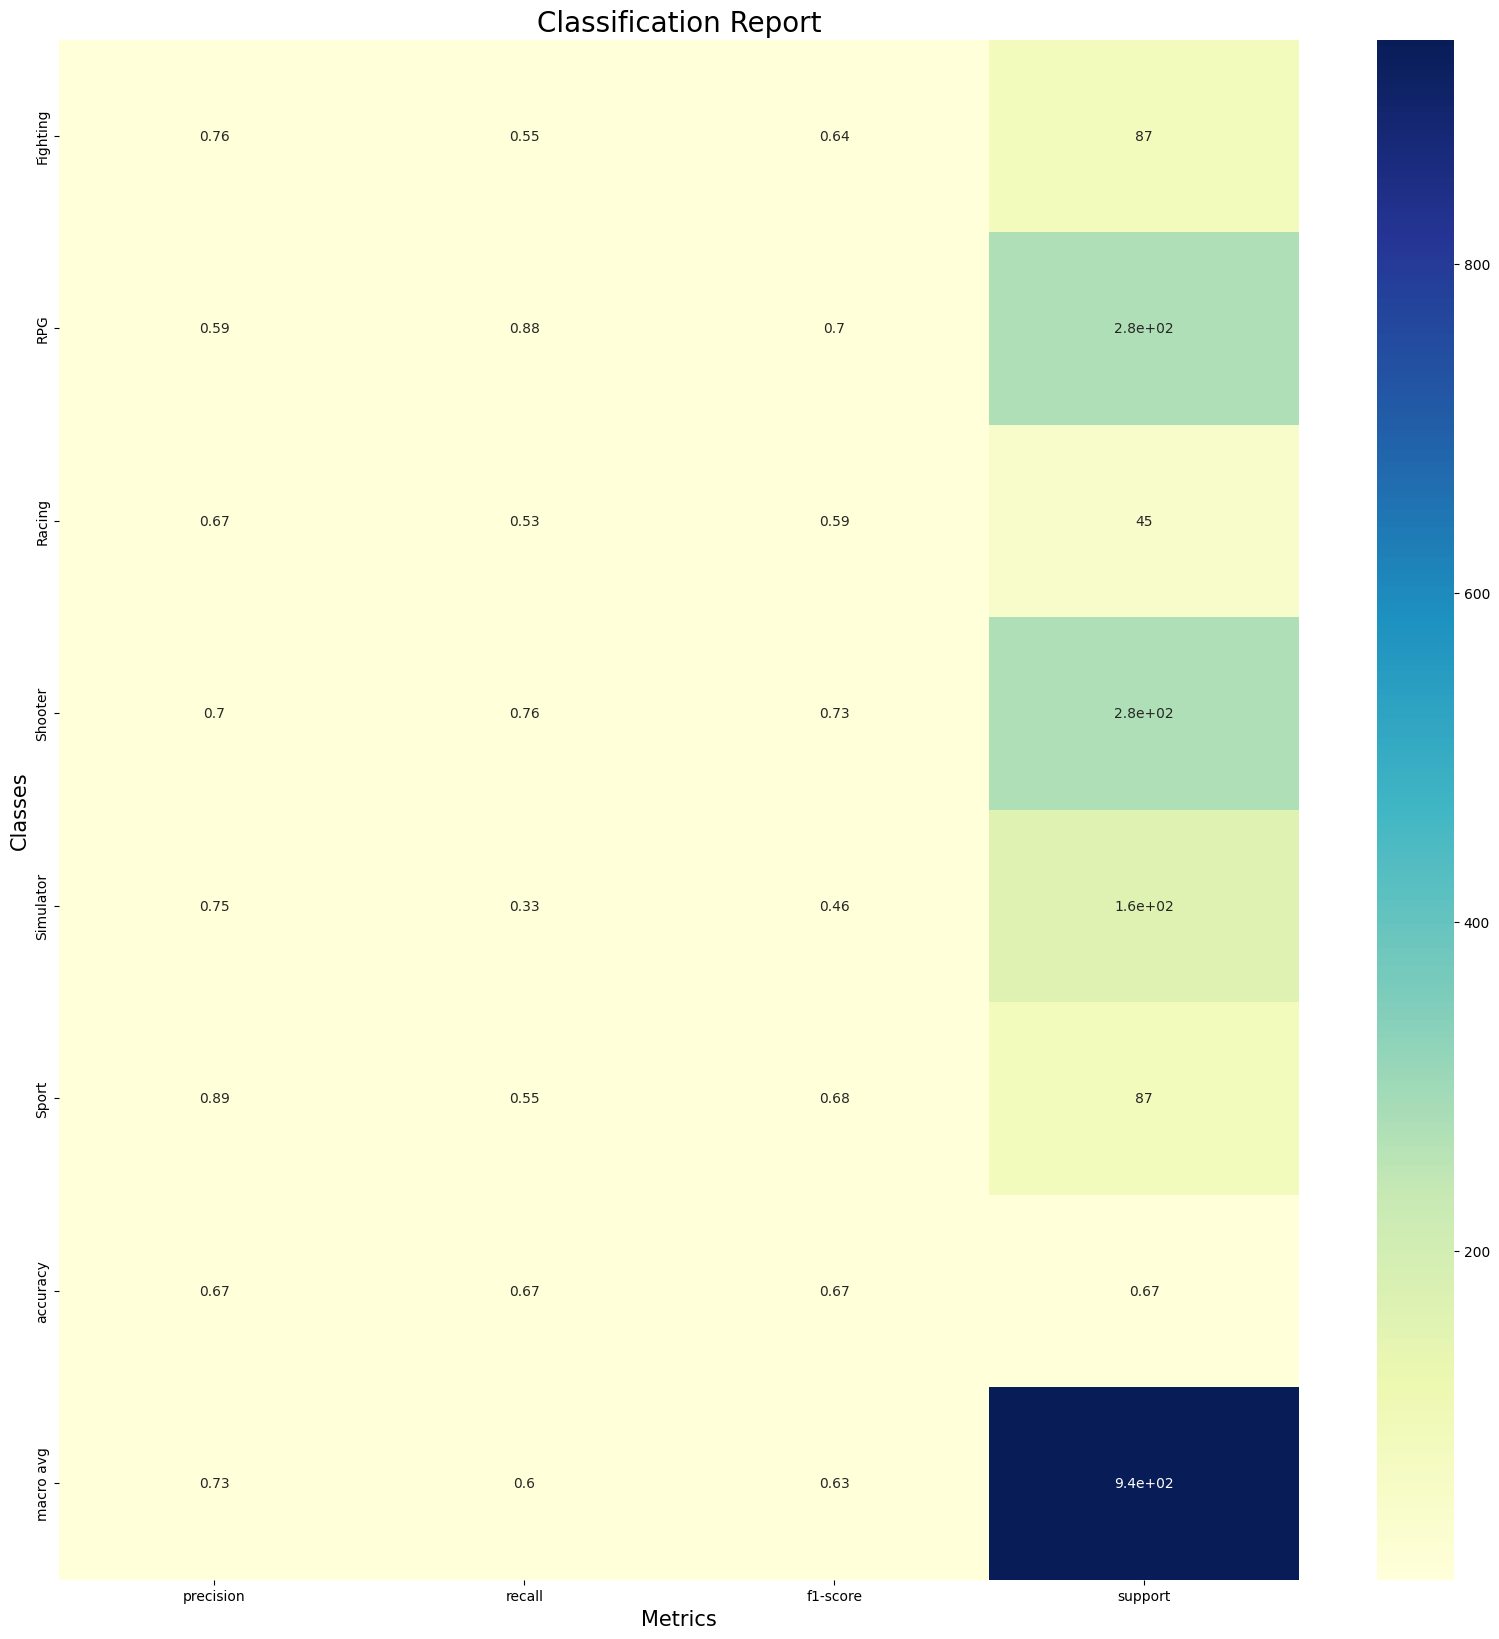

In [355]:
report = classification_report(ytest, predicted, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu")
plt.title("Classification Report", fontsize=20)
plt.xlabel("Metrics", fontsize=15)
plt.ylabel("Classes", fontsize=15)
plt.show()

<a id='sub_section_6_3'></a>
### CountVectorizer & TfidfTransformer & LogisticRegression - Pipeline

In [356]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)),
               ])
logreg.fit(Xtrain, ytrain)

ypred = logreg.predict(Xtest)

print('accuracy %s' % round(accuracy_score(ypred, ytest),2))


accuracy 0.7


In [357]:
df_model = pd.DataFrame({"Desc":Xtest, "ACTUAL":ytest, "Predicted":ypred})
df_model.sample(10)

Desc     ACTUAL Predicted
3947  overhead play jeep driver gunner rescu pow com...    Shooter   Shooter
2505  embark journey reclaim crown drangleic king ve...        RPG       RPG
3391  nintendog japanes ニンテンドッグス hepburn nintendoggu...  Simulator  Fighting
3797  chronicl riddick assault dark athena new actio...    Shooter   Shooter
3477  jim power mutant planet platform game design d...    Shooter   Shooter
5886  discov uniqu combin branch stori innov combat ...        RPG       RPG
2623  crypt necrodanc hardcor roguelik rhythm game s...        RPG       RPG
374   jrpg sequel earthbound begin ness young boy li...        RPG       RPG
1684  blazblu chrono phantasma extend former dub bla...   Fighting  Fighting
476   rockman minus infin fan made overhaul rockman ...    Shooter   Shooter

In [358]:
report = metrics.classification_report(ytest, predicted)
print(report)

              precision    recall  f1-score   support

    Fighting       0.10      0.06      0.07       103
         RPG       0.31      0.47      0.38       274
      Racing       0.06      0.05      0.05        41
     Shooter       0.31      0.33      0.32       284
   Simulator       0.14      0.06      0.09       163
       Sport       0.07      0.06      0.06        71

    accuracy                           0.26       936
   macro avg       0.17      0.17      0.16       936
weighted avg       0.23      0.26      0.24       936



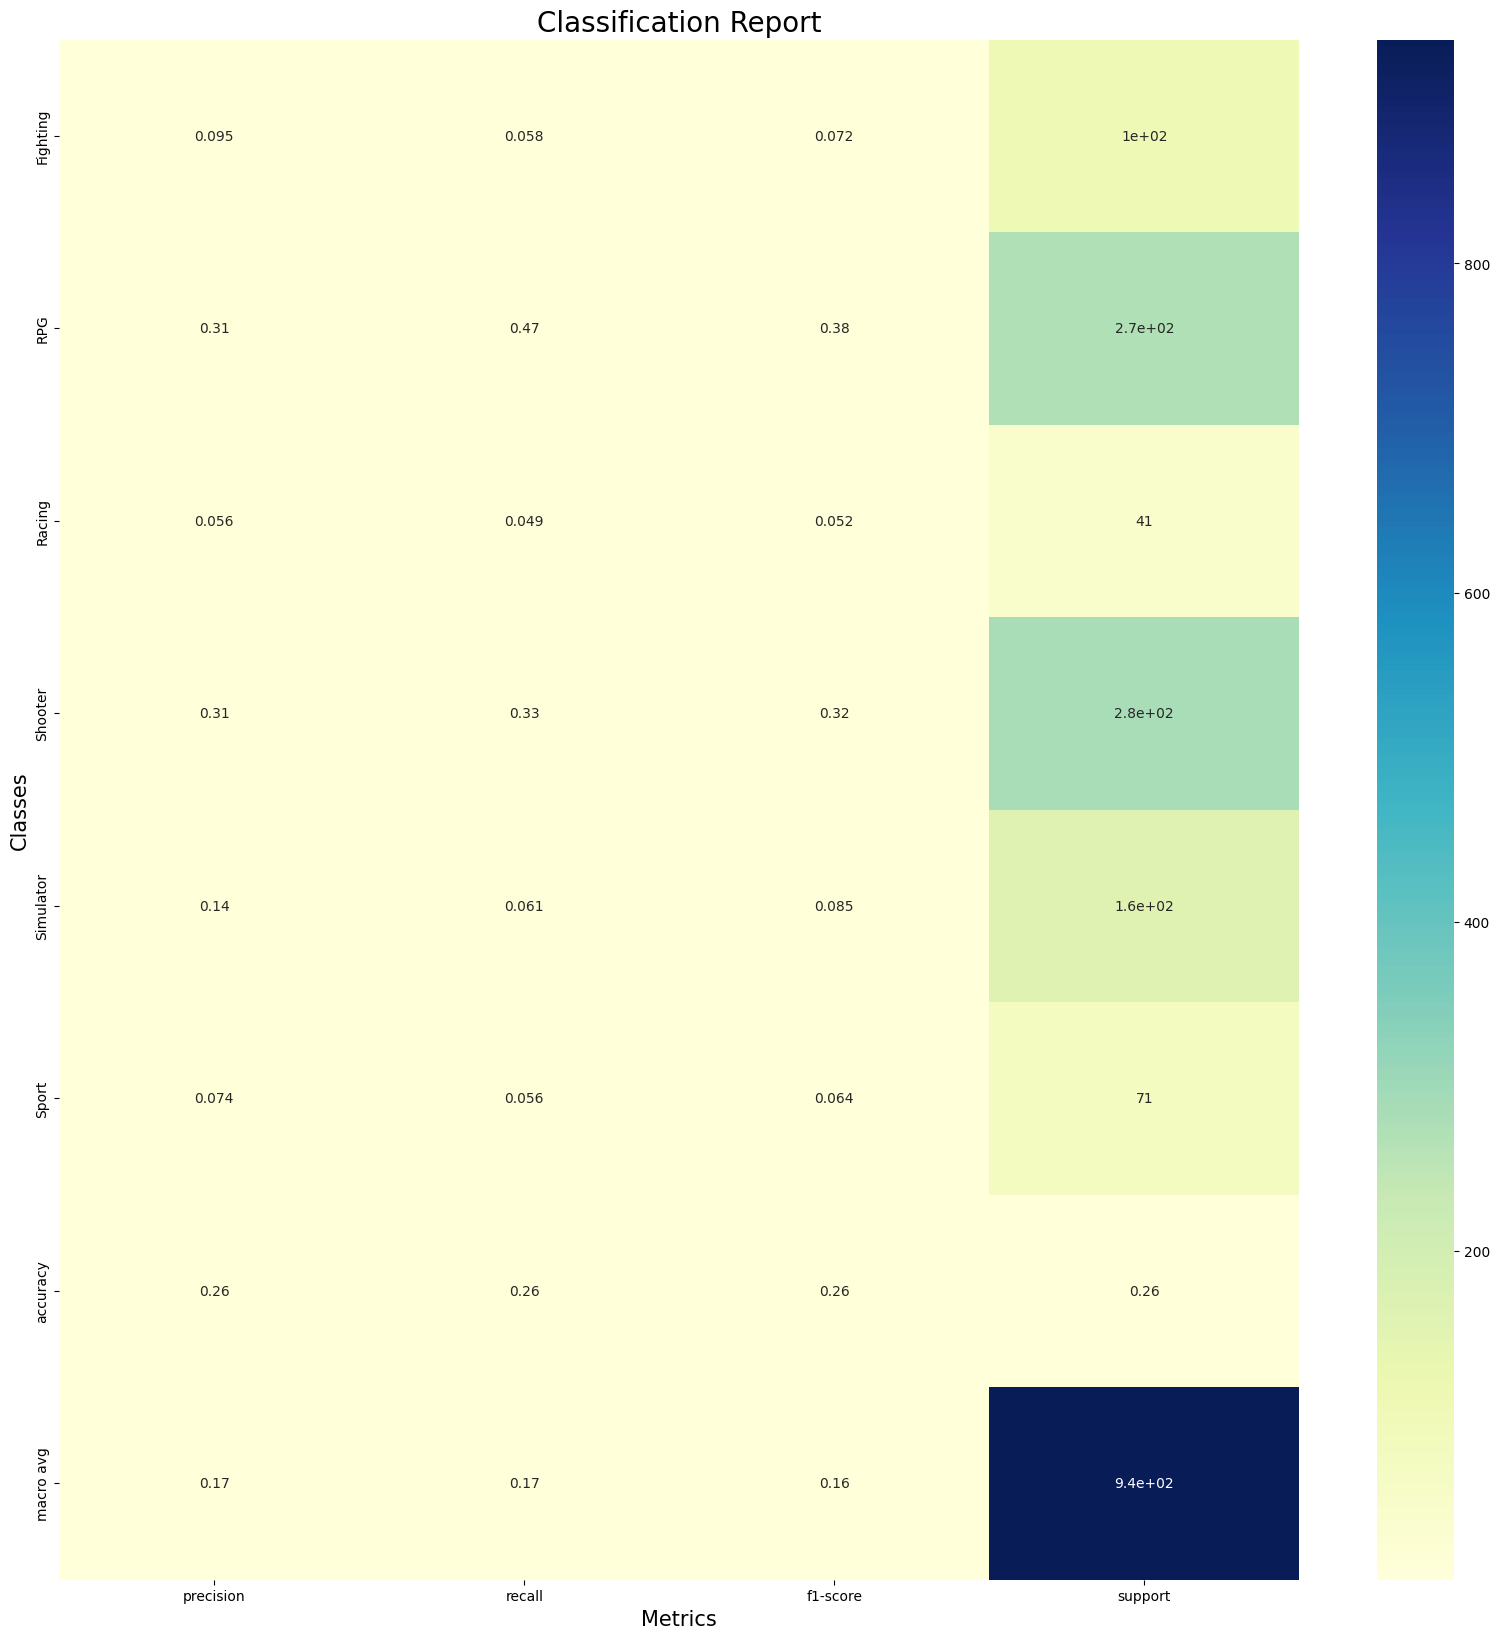

In [359]:
report = classification_report(ytest, predicted, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu")
plt.title("Classification Report", fontsize=20)
plt.xlabel("Metrics", fontsize=15)
plt.ylabel("Classes", fontsize=15)
plt.show()

<a id='sub_section_6_4'></a>
### SVM

In [362]:
df = df.sample(frac = 1)
X = df['Description']
y = df['Genres']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words="english", max_features=10000)),
    ('norm', preprocessing.Normalizer(norm='l1')),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          random_state=42,
                          max_iter=10000))
])
 
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)
df_svm = pd.DataFrame({"Desc":X_test, "Actual":y_test, "Prediction":svm_predictions})
ensemble_clf = VotingClassifier(estimators=[
    ('svm', svm_pipeline)
], voting='hard')

print("SVM Report:")
print(classification_report(y_test, svm_predictions))

SVM Report:
              precision    recall  f1-score   support

    Fighting       0.82      0.62      0.70        94
         RPG       0.68      0.87      0.77       306
      Racing       0.59      0.53      0.56        38
     Shooter       0.70      0.79      0.74       263
   Simulator       0.76      0.42      0.54       156
       Sport       0.87      0.59      0.71        79

    accuracy                           0.71       936
   macro avg       0.74      0.64      0.67       936
weighted avg       0.73      0.71      0.70       936



In [365]:
df_svm.sample(10)

Desc     Actual Prediction
1138  dream battl last king fighter come favorit cha...   Fighting   Fighting
3054  object bosconian score mani point possibl dest...    Shooter    Shooter
7527  bless fantasi mmorpg dive beauti world bless b...        RPG        RPG
1841  attempt conquer world guardian encas castl bri...        RPG        RPG
5386  one year event final fantasi young protagonist...        RPG        RPG
5275  bungi emphas univers destini aliv event may ha...    Shooter    Shooter
2389  new era shoot loot begin play one four new vau...    Shooter    Shooter
4235  star war episod racer let particip famous pod ...     Racing     Racing
808   thief gold perspect stealth game first game us...  Simulator    Shooter
2353  stori unexpect encount mario irrever rabbid mu...        RPG        RPG

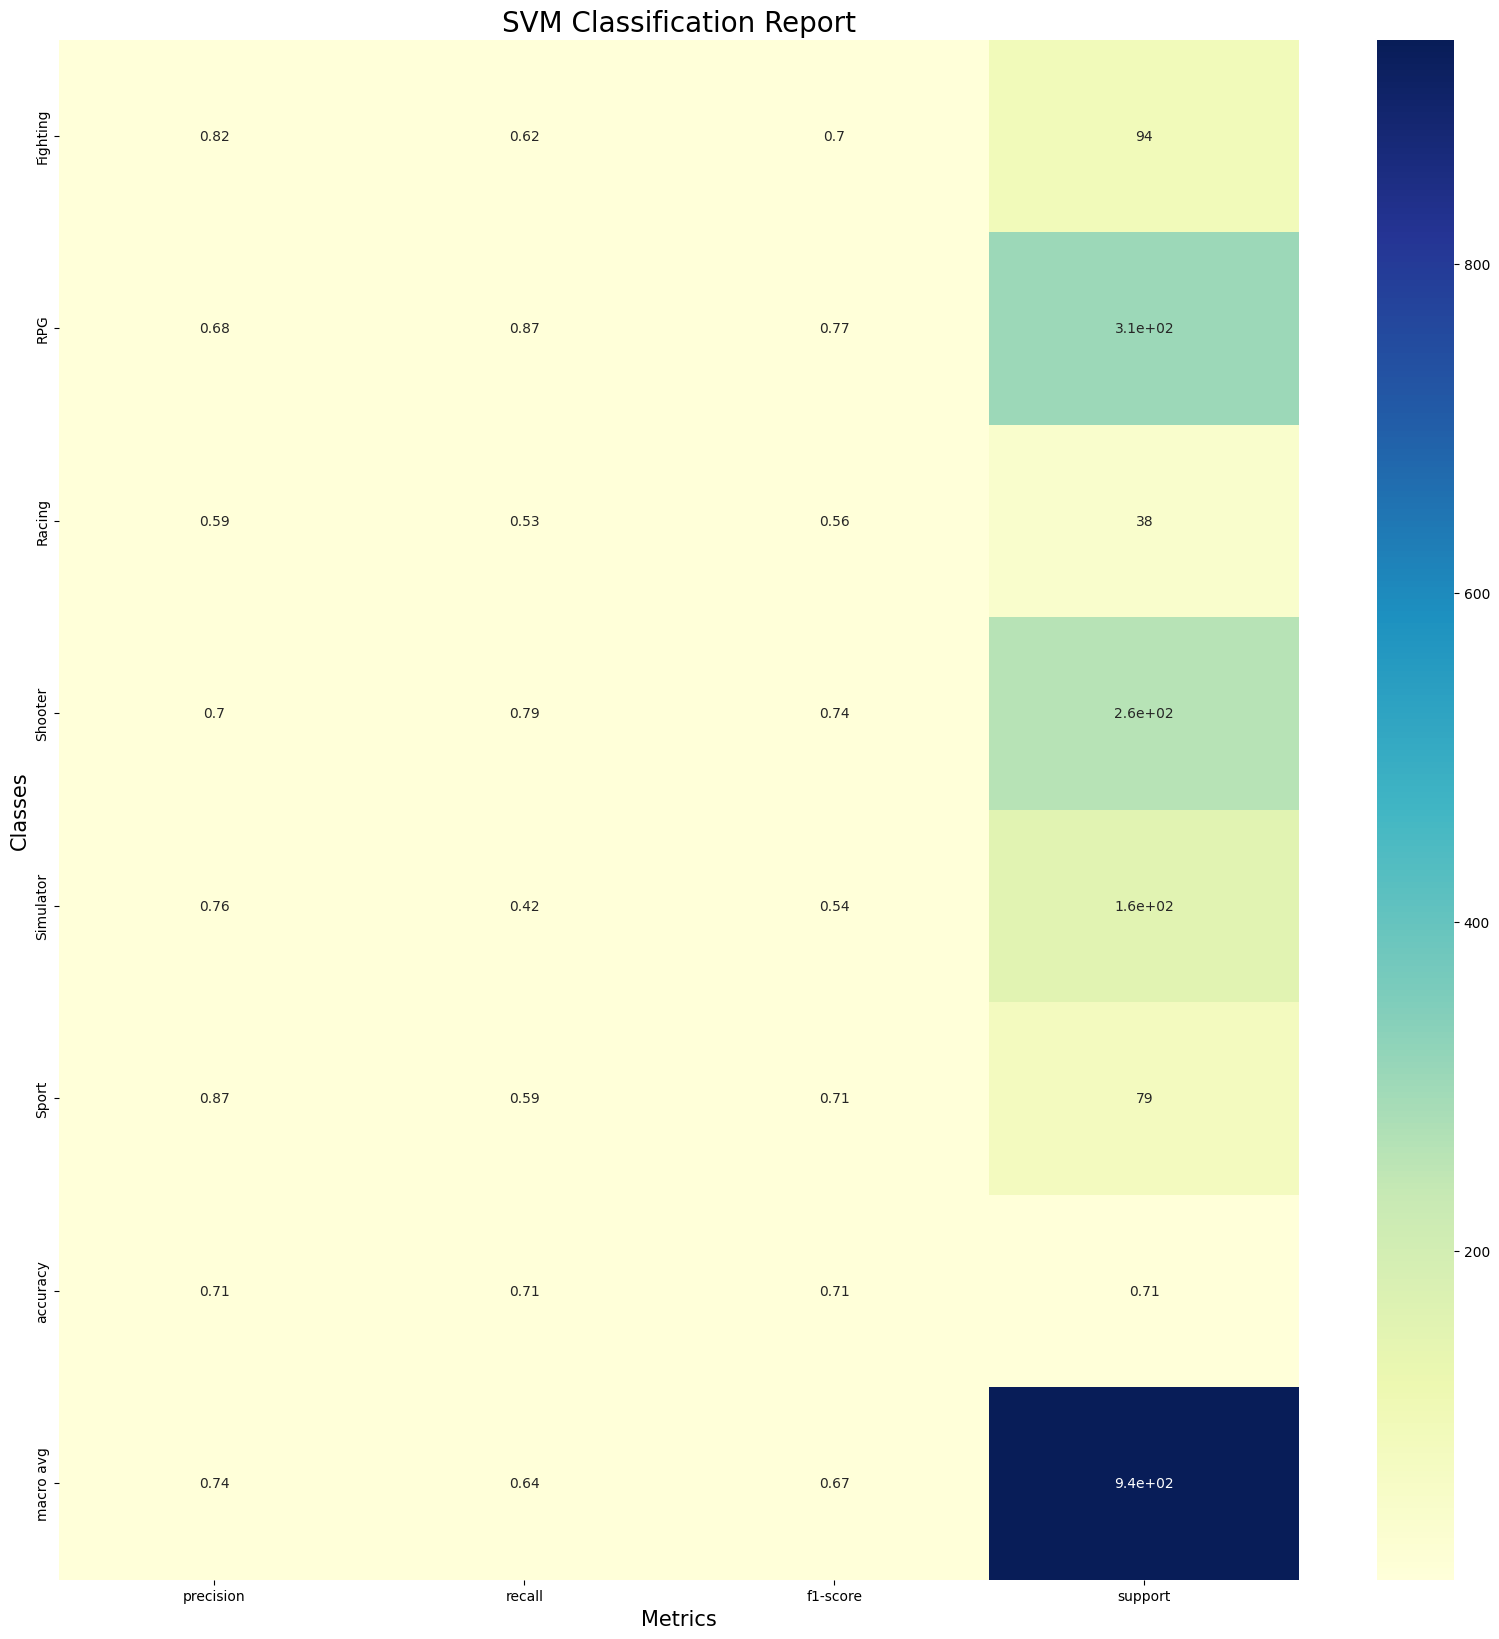

In [366]:
report = classification_report(y_test, svm_predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu")
plt.title("SVM Classification Report", fontsize=20)
plt.xlabel("Metrics", fontsize=15)
plt.ylabel("Classes", fontsize=15)
plt.show()

<a id='chapter7'></a>
## Lets give new texts for testing the SVM model

In [375]:
desc = ["this is an shooter game play with friends 6vs6. teams split to terrorists and counter-terrorists\
the terrorist should bomb or kill everyone while the counter-terrorists must defense and kill the terrorist"]
svm_prediction = svm_pipeline.predict(desc)
print("Actual = Shooter")
print(f"SVM Predicted = {svm_prediction}")

Actual = Shooter
SVM Predicted = ['Shooter']


In [376]:
desc = ["this football game about the champions league called fifa all you have to do is score goals and win\
against other clubs be the champion"]
svm_prediction = svm_pipeline.predict(desc)
print("Actual = Sport")
print(f"SVM Predicted = {svm_prediction}")

Actual = Sport
SVM Predicted = ['Sport']


In [380]:
desc = ["this is an fantasy role play game take your character to the next level and head\
out to survive against the monsters with your sword"]
svm_prediction = svm_pipeline.predict(desc)
print("Actual = RPG")
print(f"SVM Predicted = {svm_prediction}")

Actual = RPG
SVM Predicted = ['RPG']


In [381]:
desc = ["race against time outsmart the cops and take on weekly qualifiers to \
reach the grand lakeshore ultimate street racing"]
svm_prediction = svm_pipeline.predict(desc)
print("Actual = Racing")
print(f"SVM Predicted = {svm_prediction}")

Actual = Racing
SVM Predicted = ['Racing']


<a id='chapter8'></a>
# CREDITS

* YouTube & Kaggle - Tutorials for Classification using NLP
* matplotlib
* scikit-learn
* Backloggd